# deepBreaks applications
## deepBreaks reveals important SARS-CoV-2 regions associated with Alpha and Delta variants  
Variants occur with new mutations in the virus genome. Most mutations in the SARS-CoV-2 genome do not affect the functioning of the virus. However, mutations in the spike protein of SARS-CoV-2, which binds to receptors on cells lining the inside of the human nose, may make the virus easier to spread or affect how well vaccines protect people. Other mutations may lead to SARS-CoV-2 being less responsive to treatments for COVID-19. Variants of SARS-CoV-2 have been categorized into multiple variants, but based on their effect on public health, only five of these have been labeled as variants of concern. Among these five variants, we are going to study the mutations in the spike protein of the sequences of Alpha (B.1.1.7): the first variant of concern described in the United Kingdom (UK) in late December 2020 and Delta (B.1.617.2): first reported in India in December 2020. We used the publicly available data from the GSAID28 and obtained 900 sequences of spike protein region of Alpha (450 samples) and Delta (450 samples) variants. We used MAFFT algorithm with PAM 200 to align these sequences. Then, we used deepBreaks to analyze the data and find the most important (predictive) positions in these sequences in terms of classifying the variants.


In [1]:
# importing deepBreaks libraries 
from deepBreaks.utils import get_models, get_scores, get_params, make_pipeline
from deepBreaks.preprocessing import MisCare, ConstantCare, URareCare, CustomOneHotEncoder
from deepBreaks.preprocessing import FeatureSelection, CollinearCare, CustomStandardScaler
from deepBreaks.preprocessing import read_data, balanced_classes
from deepBreaks.models import model_compare_cv, finalize_top, importance_from_pipe, mean_importance, summarize_results
from deepBreaks.visualization import plot_scatter, dp_plot, plot_imp_model, plot_imp_all
import warnings
import datetime
import os

In [2]:
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [3]:
# defining user params, file pathes, analysis type

# path to sequences
seqFileName = '../../deepBreaks_data/SarsCov2Variant/AlphaAndOmicronNoNL.fasta'
metaDataFileName = '../../deepBreaks_data/SarsCov2Variant/AlphaAndOmicronFullMetadata.tsv'
# name of the phenotype
mt = 'variant_short'

# type of the sequences
seq_type = 'nu'
# type of the analysis if it is a classification model, then we put cl instead of reg
ana_type = 'cl'
sampleFrac=1

In [4]:
# making a unique directory for saving the reports of the analysis
print('direcory preparation')
dt_label = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
seqFile = seqFileName.split('.')[0]
report_dir = str(seqFile +'_' + mt + '_' + dt_label)
os.makedirs(report_dir)

direcory preparation


In [5]:
%%time
# importing sequences data
print('reading meta-data')
# importing metadata
meta_data = read_data(metaDataFileName, seq_type = None, is_main=False)

# importing sequences data
print('reading fasta file')
tr = read_data(seqFileName, seq_type = seq_type, is_main=True, gap_threshold=0.7)

print('Shape of data is: ', tr.shape)

reading meta-data
reading fasta file
Shape of data is:  (19482, 3814)
CPU times: user 2min 1s, sys: 37.2 s, total: 2min 38s
Wall time: 2min 59s


**Attention**: metadata and sequences data should have the names as their row names and for each sequence their must be a value in the meta data file.

In [6]:
print('metadata looks like this:')
meta_data.head()

metadata looks like this:


,variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-10|EPI_ISL_1058013|Original|hCoV-19^^Wales|Human|Lighthouse Lab in Alderley Park|Wellcome Sanger Institute for the COVID-19 Genomics UK (COG-UK) Consortium|Davies|United Kingdom,Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03-25|EPI_ISL_1488132|Original|hCoV-19^^England|Human|Randox Laboratories|Wellcome Sanger Institute for the COVID-19 Genomics UK (COG-UK) Consortium|Davies|United Kingdom,Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03-22|EPI_ISL_1452219|Original|hCoV-19^^England|Human|Lighthouse Lab in Glasgow|Wellcome Sanger Institute for the COVID-19 Genomics UK (COG-UK) Consortium|Davies|United Kingdom,Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|2021-03-14|EPI_ISL_1483464|Original|hCoV-19^^Dublin|Human|National Virus Reference Laboratory|National Virus Reference Laboratory|Gonzalez|Ireland,Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06|EPI_ISL_1052704|Original|hCoV-19^^Wales|Human|Originating lab|Public Health Wales Microbiology Cardiff Wales Specialist Virology Centre|Moore|United Kingdom,Alpha


In [7]:
indx = [ind.split(' ')[0] for ind in meta_data.index]
meta_data.index = indx

In [8]:
meta_data.head()

,variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-10|EPI_ISL_1058013|Original|hCoV-19^^Wales|Human|Lighthouse,Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03-25|EPI_ISL_1488132|Original|hCoV-19^^England|Human|Randox,Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03-22|EPI_ISL_1452219|Original|hCoV-19^^England|Human|Lighthouse,Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|2021-03-14|EPI_ISL_1483464|Original|hCoV-19^^Dublin|Human|National,Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06|EPI_ISL_1052704|Original|hCoV-19^^Wales|Human|Originating,Alpha


In [9]:
len(set(tr.index))==tr.shape[0]

True

In [10]:
meta_data = meta_data.reset_index().drop_duplicates('index', keep='first')
meta_data.set_index('index', inplace=True)
meta_data.index.name = None

In [11]:
len(set(meta_data.index))==meta_data.shape[0]

True

In [12]:
meta_data.head()

,variant_short
Spike|hCoV-19/Wales/ALDP-1294127/2021|2021-02-10|EPI_ISL_1058013|Original|hCoV-19^^Wales|Human|Lighthouse,Alpha
Spike|hCoV-19/England/RAND-1477F5B/2021|2021-03-25|EPI_ISL_1488132|Original|hCoV-19^^England|Human|Randox,Alpha
Spike|hCoV-19/England/QEUH-144ECFC/2021|2021-03-22|EPI_ISL_1452219|Original|hCoV-19^^England|Human|Lighthouse,Alpha
Spike|hCoV-19/Ireland/D-NVRL-21IRL73431/2021|2021-03-14|EPI_ISL_1483464|Original|hCoV-19^^Dublin|Human|National,Alpha
Spike|hCoV-19/Wales/PHWC-4C7E8F/2021|2021-02-06|EPI_ISL_1052704|Original|hCoV-19^^Wales|Human|Originating,Alpha


In [13]:
tr = tr.merge(meta_data.loc[:, mt],  left_index=True, right_index=True, how='inner')
y = tr.loc[:, mt].values
tr.drop(mt, axis=1, inplace=True)
print('Shape of data is: ', tr.shape)

Shape of data is:  (19481, 3814)


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print(le.classes_)

['Alpha' 'Omicron']


### Preprocessing
In this step, we do all these steps:
1. dropping columns with a number of missing values above a certain threshold  
2. dropping zero entropy columns  
3. imputing missing values with the mode of that column  
4. replacing cases with a frequency below a threshold (default 1.5%) with the mode of that column
5. dropping zero entropy columns
6. use statistical tests (each position against the phenotype) and drop columns with p-values below a threshold (default 0.25)
7. one-hot encode the remaining columns
8. calculate the pair-wise distance matrix for all of the columns
9. use the distance matrix for DBSCAN and cluster the correlated positions together
10. keep only one column (closes to center of each cluster) for each group and drop the rest from the training data set

In [15]:
prep_pipeline = make_pipeline(
    steps=[
        ('mc', MisCare(missing_threshold=0.25)),
        ('cc', ConstantCare()),
        ('ur', URareCare(threshold=0.05)),
        ('cc2', ConstantCare()),
        ('one_hot', CustomOneHotEncoder()),
        ('feature_selection', FeatureSelection(model_type=ana_type, alpha=0.25, keep=True)),
        ('st_sc', CustomStandardScaler()),
        ('collinear_care', CollinearCare(dist_method='correlation', threshold=0.25, keep=True))
    ])

In [16]:
%%time
report, top = model_compare_cv(X=tr, y=y, preprocess_pipe=prep_pipeline,
                               models_dict=get_models(ana_type=ana_type),
                               scoring=get_scores(ana_type=ana_type),
                               report_dir=report_dir,
                               cv=0.3, ana_type=ana_type, cache_dir=None)

Fitting rf...
Fitting Adaboost...
Fitting et...
Fitting lg...
Fitting gbc...
Fitting dt...
Fitting xgb...
Fitting lgbm...
CPU times: user 10.7 s, sys: 4.75 s, total: 15.5 s
Wall time: 3min 49s


In [17]:
report

,Accuracy,AUC,F1,Recall,Precision
rf,0.995723,0.998614,0.995722,0.995711,0.995734
et,0.995723,0.998616,0.995722,0.995711,0.995734
gbc,0.995723,0.999118,0.995722,0.995711,0.995734
dt,0.995723,0.998616,0.995722,0.995711,0.995734
xgb,0.995723,0.999140,0.995722,0.995711,0.995734
lgbm,0.995723,0.999162,0.995722,0.995711,0.995734
lg,0.995723,0.999356,0.995722,0.995702,0.995746
Adaboost,0.992814,0.999386,0.992812,0.992747,0.992929


In [18]:
%%time
top = finalize_top(X=tr, y=y, top_models=top, grid_param={},report_dir=report_dir, cv=0.3)

Tuning rf...
Tuning et...
Tuning gbc...
CPU times: user 1min 7s, sys: 5.16 s, total: 1min 12s
Wall time: 1min 8s


In [19]:
%%time
sr = summarize_results(top_models=top, report_dir=report_dir)

CPU times: user 35.4 ms, sys: 5.91 ms, total: 41.3 ms
Wall time: 53.8 ms


In [20]:
sr.head()

,feature,p_value,score,rf,et,gbc,mean
0,p56_T,0.0,5211.222693,0.273384,0.362186,0.007878,0.214483
1,p71_T,0.0,1858.335217,0.273384,0.362186,0.007878,0.214483
2,p72_GAP,0.0,4902.620427,0.273384,0.362186,0.007878,0.214483
3,p73_GAP,0.0,4948.626742,0.273384,0.362186,0.007878,0.214483
4,p74_GAP,0.0,4956.029686,0.273384,0.362186,0.007878,0.214483


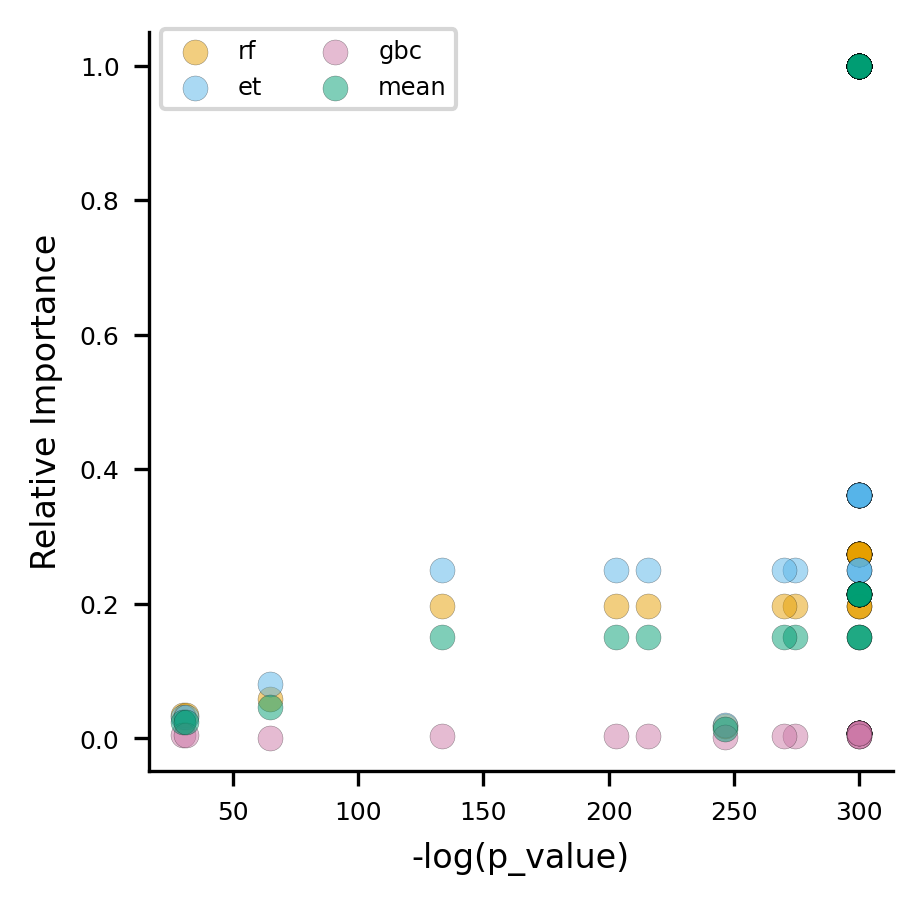

In [21]:
scatter_plot = plot_scatter(summary_result=sr, report_dir=report_dir)

In [22]:
top[0][-1].feature_names_in_

array(['p75_GAP', 'p1029_G', 'p1222_T', 'p1448_T', 'p1478_G', 'p3344_G'],
      dtype=object)

In [23]:
top[0][-1].feature_importances_

array([0.17269573, 0.03707466, 0.01150239, 0.02235791, 0.12467287,
       0.63169643])

In [24]:
%%time
mean_imp = mean_importance(top, report_dir=report_dir, aggregate_function='max')

CPU times: user 42.2 ms, sys: 5.62 ms, total: 47.8 ms
Wall time: 60.1 ms


In [25]:
mean_imp

,feature,rf,et,gbc,mean
0,1,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0
...,...,...,...,...,...
3808,3809,0.0,0.0,0.0,0.0
3809,3810,0.0,0.0,0.0,0.0
3810,3811,0.0,0.0,0.0,0.0
3811,3812,0.0,0.0,0.0,0.0


mean Done


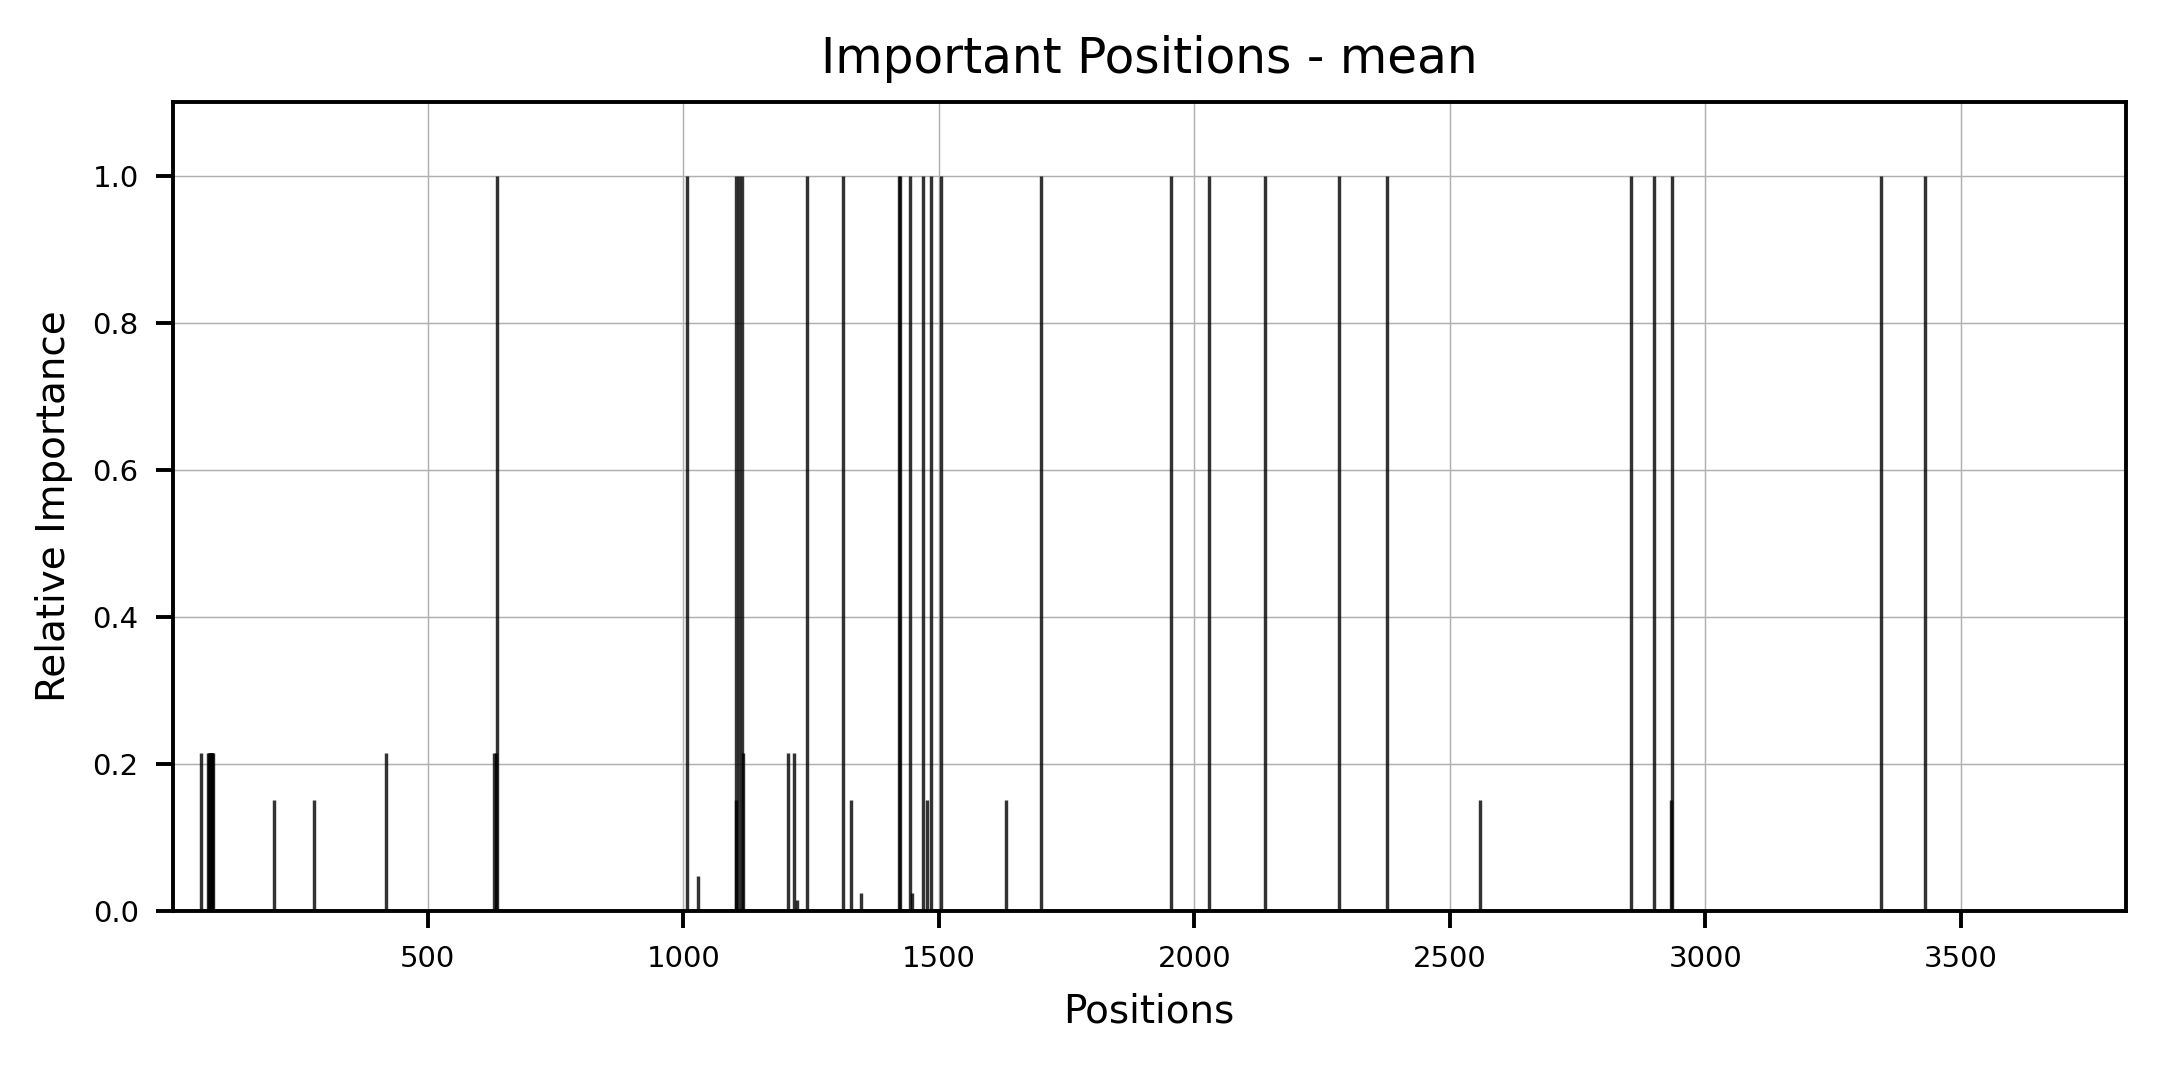

In [26]:
dp_plot(importance=mean_imp,imp_col='mean', model_name='mean', report_dir=report_dir, annotate=0)

In [27]:
tr = prep_pipeline[:4].fit_transform(tr)
y = le.inverse_transform(y)

rf Done
rf  Done
et Done
et  Done
gbc Done
gbc  Done


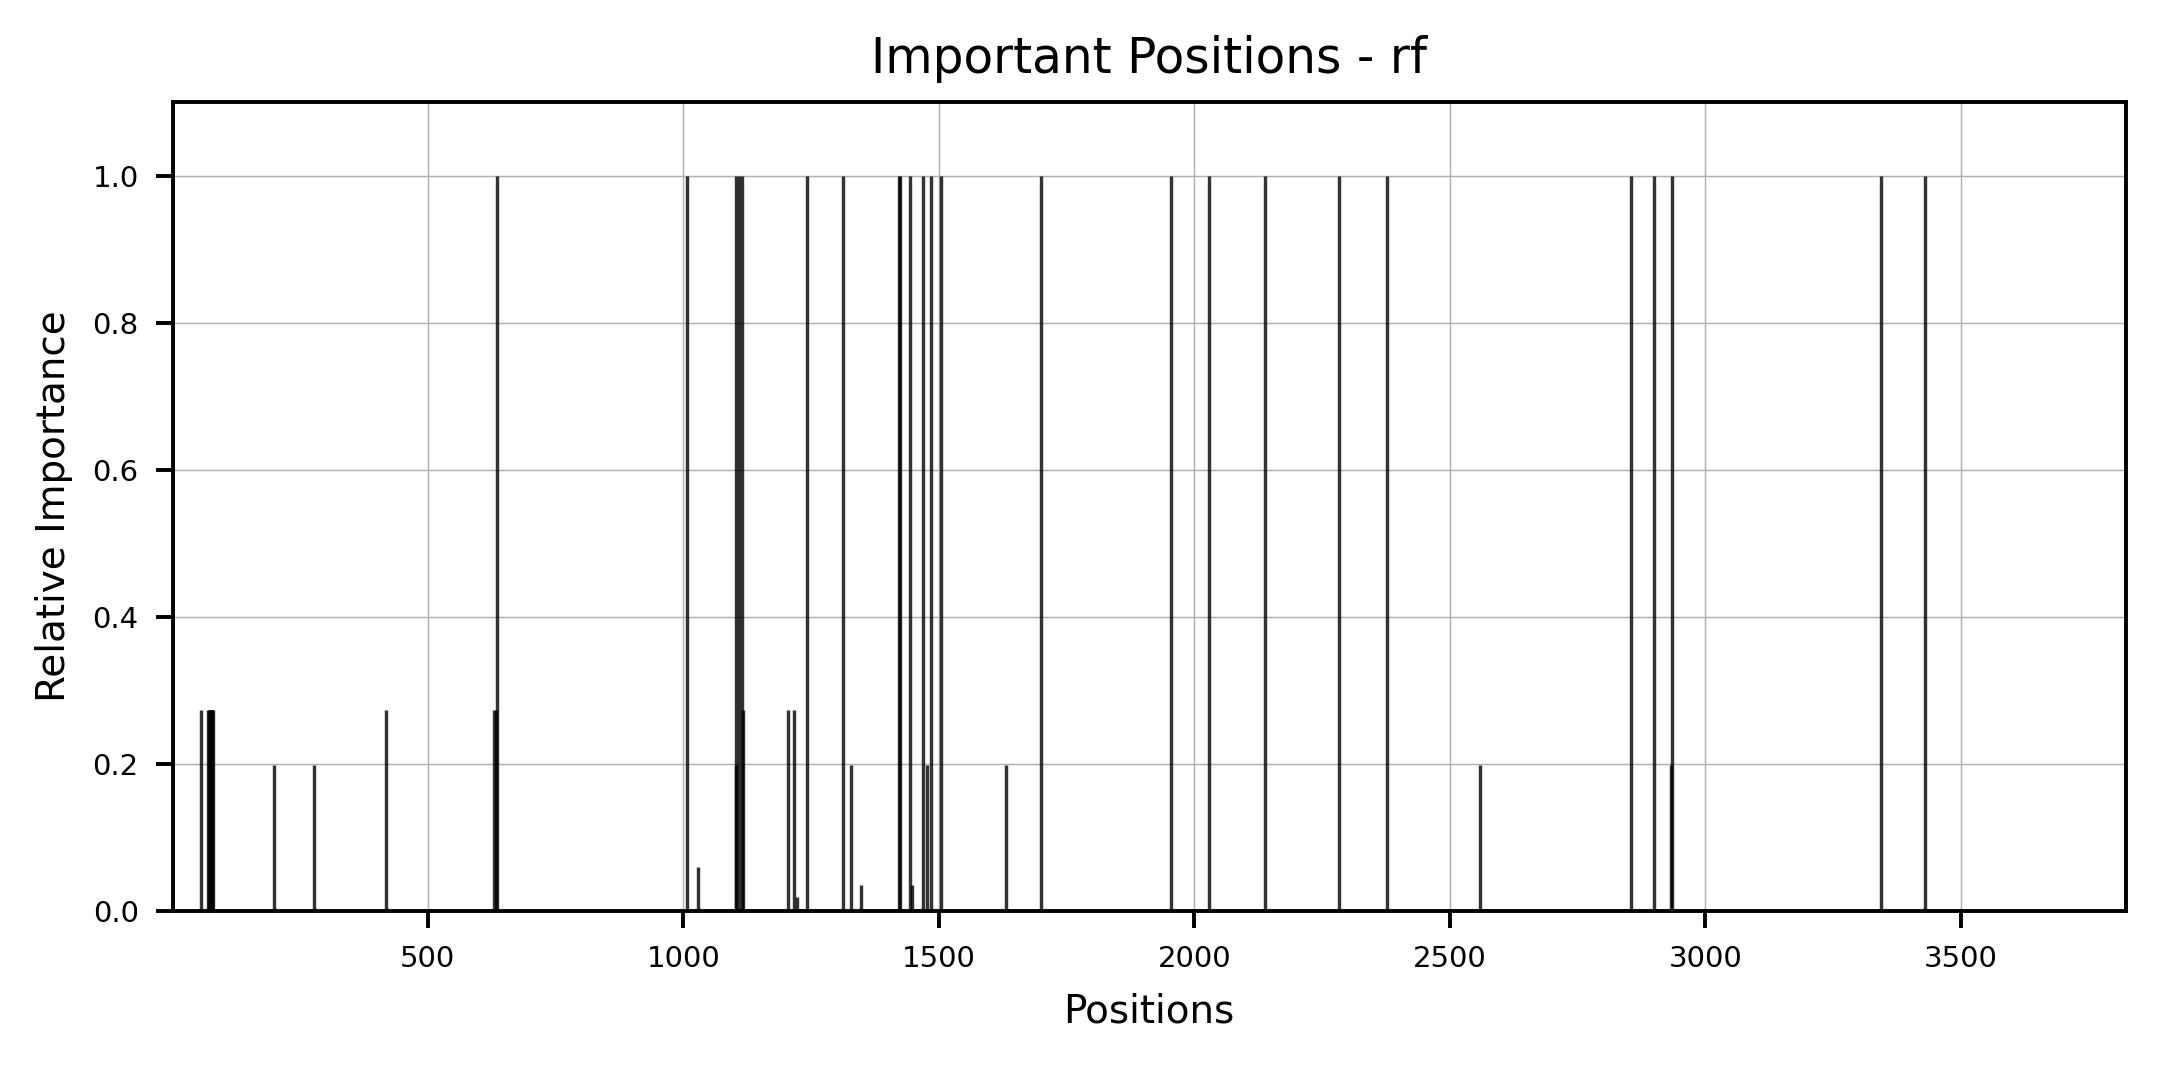

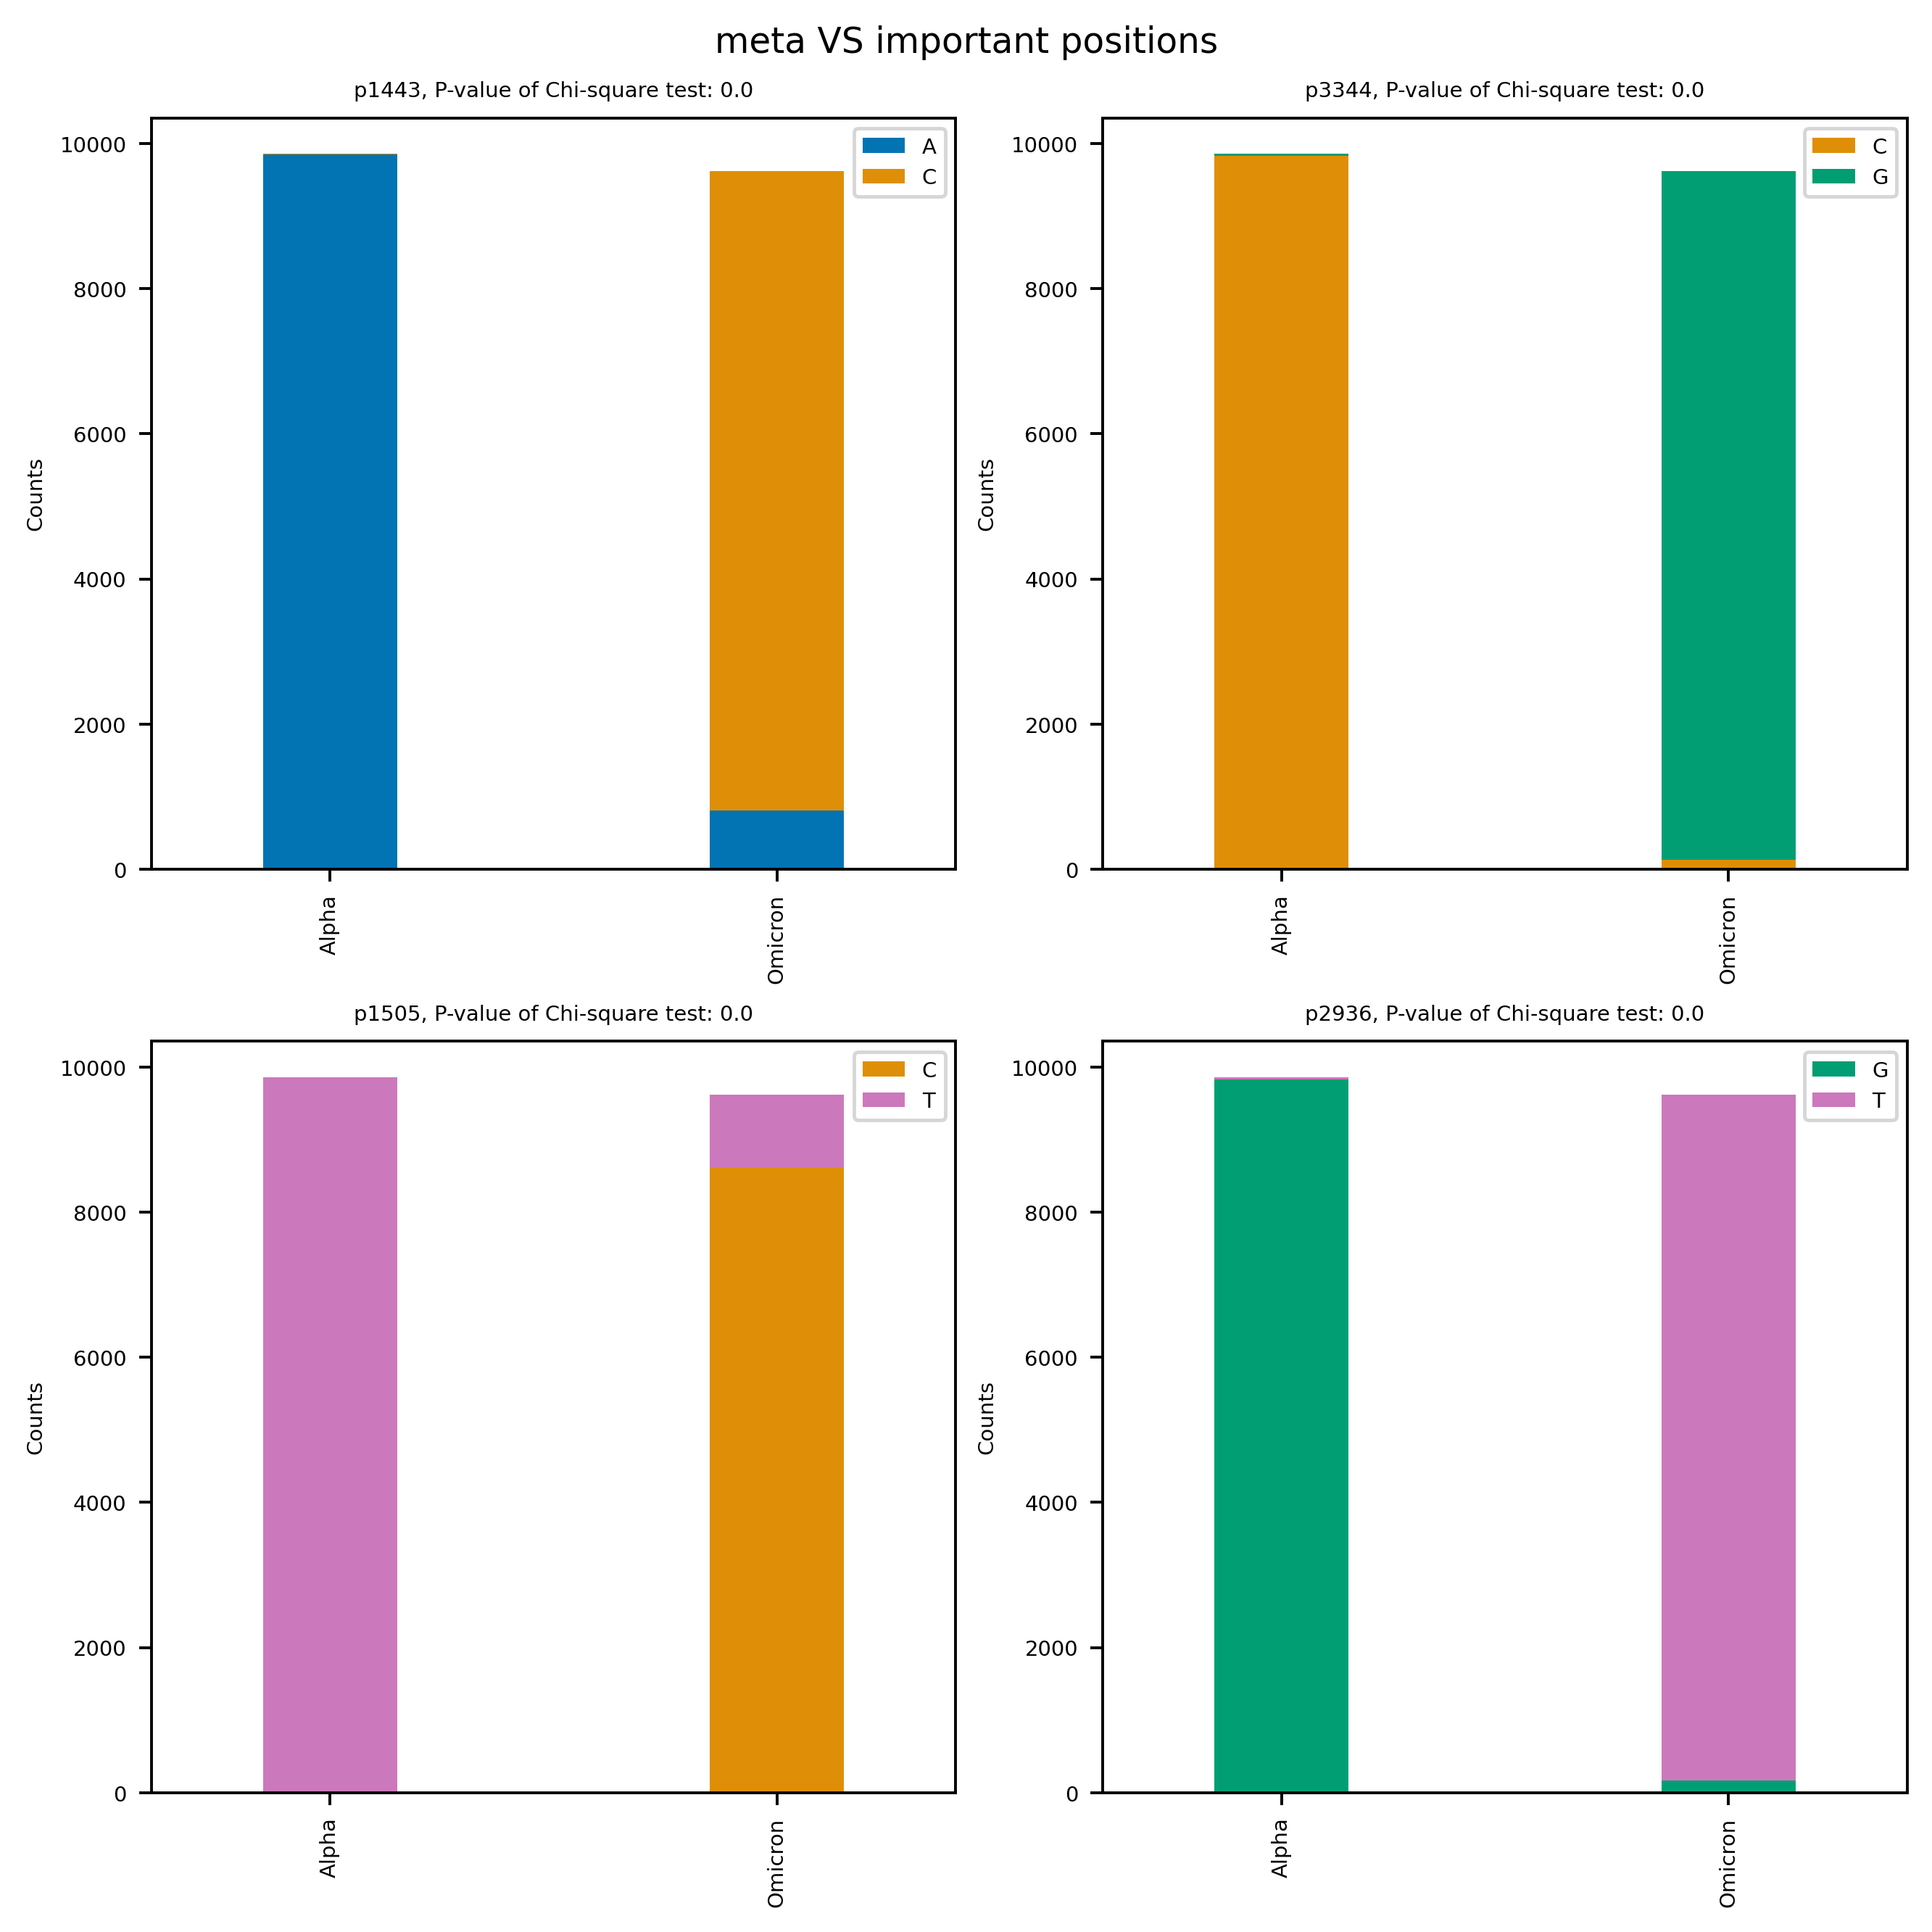

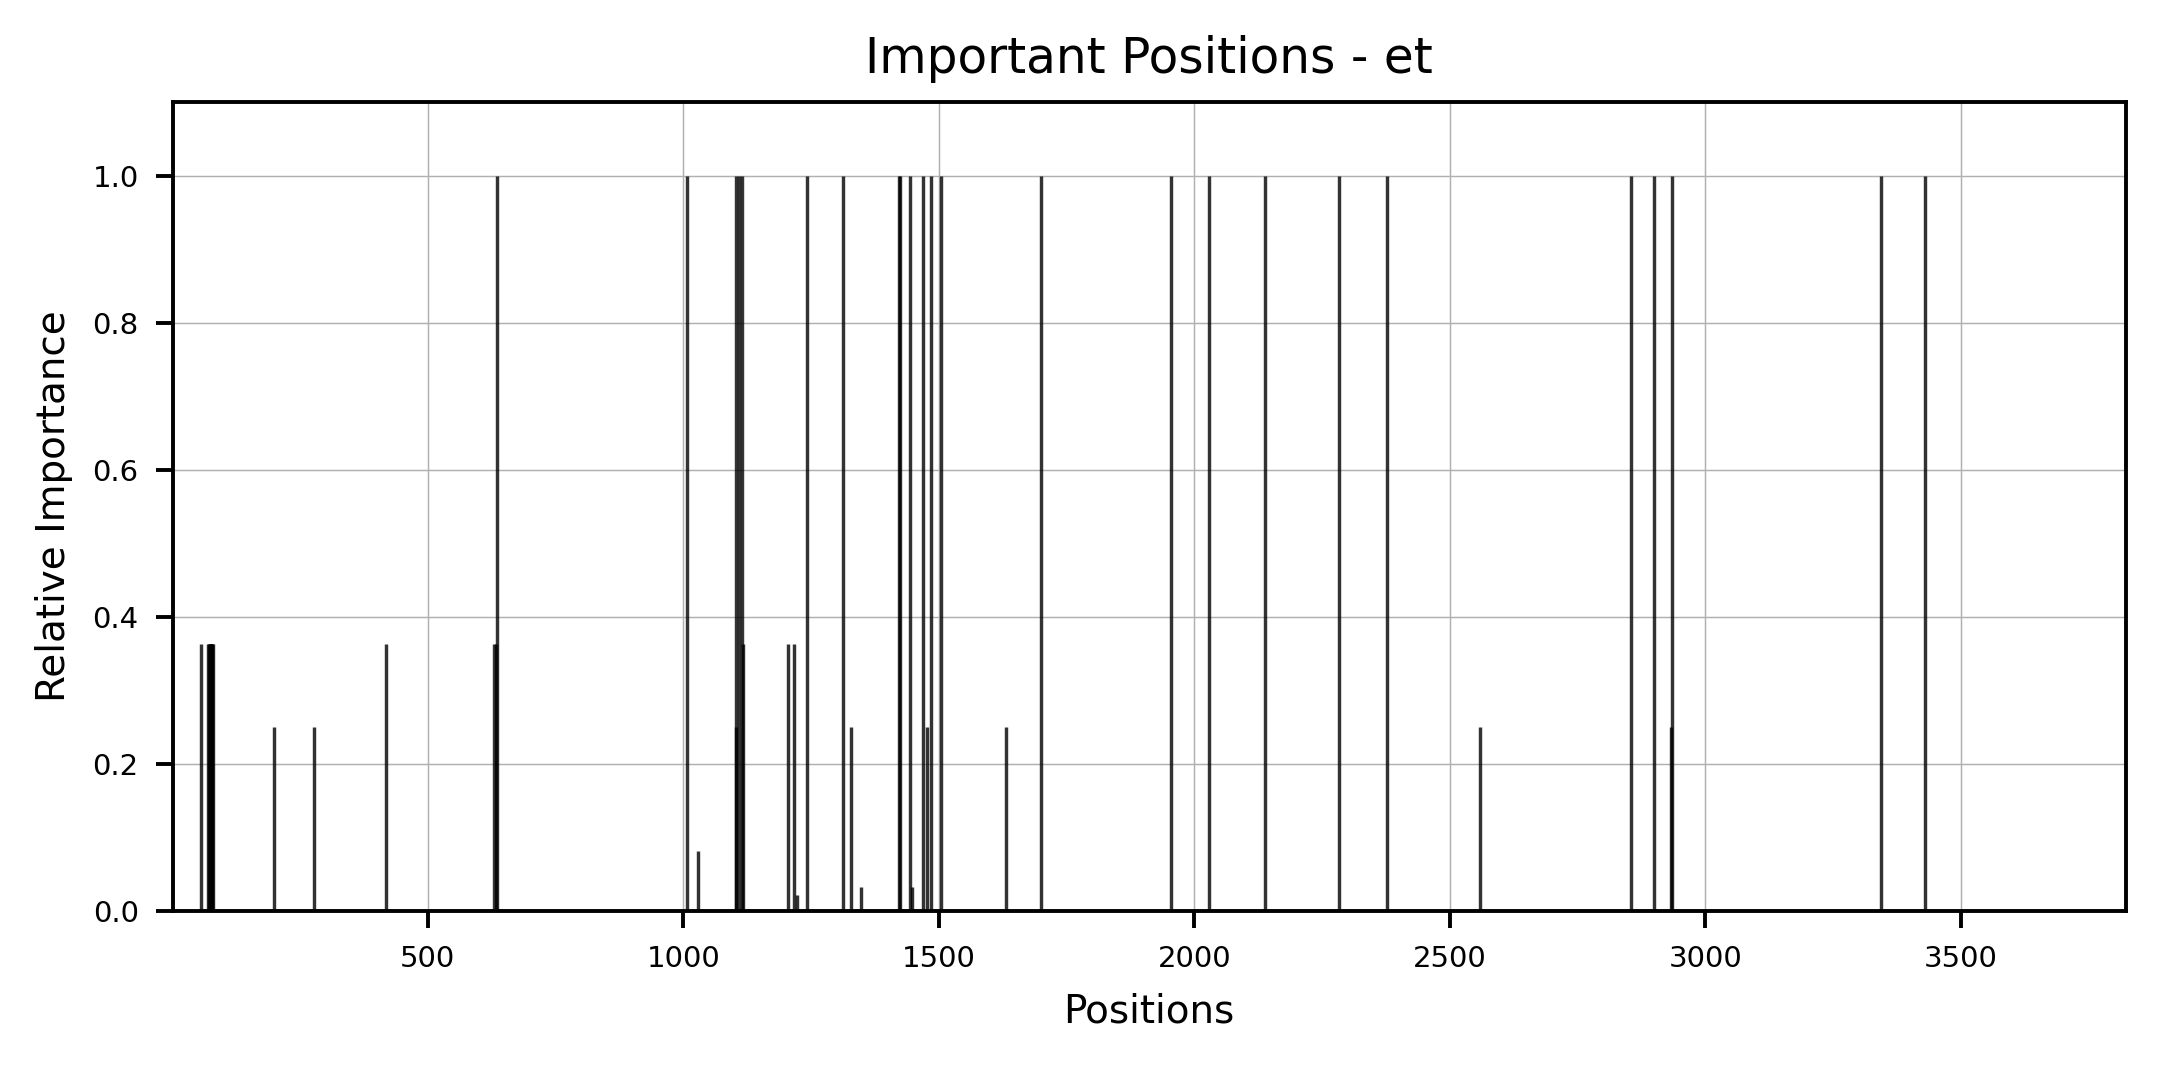

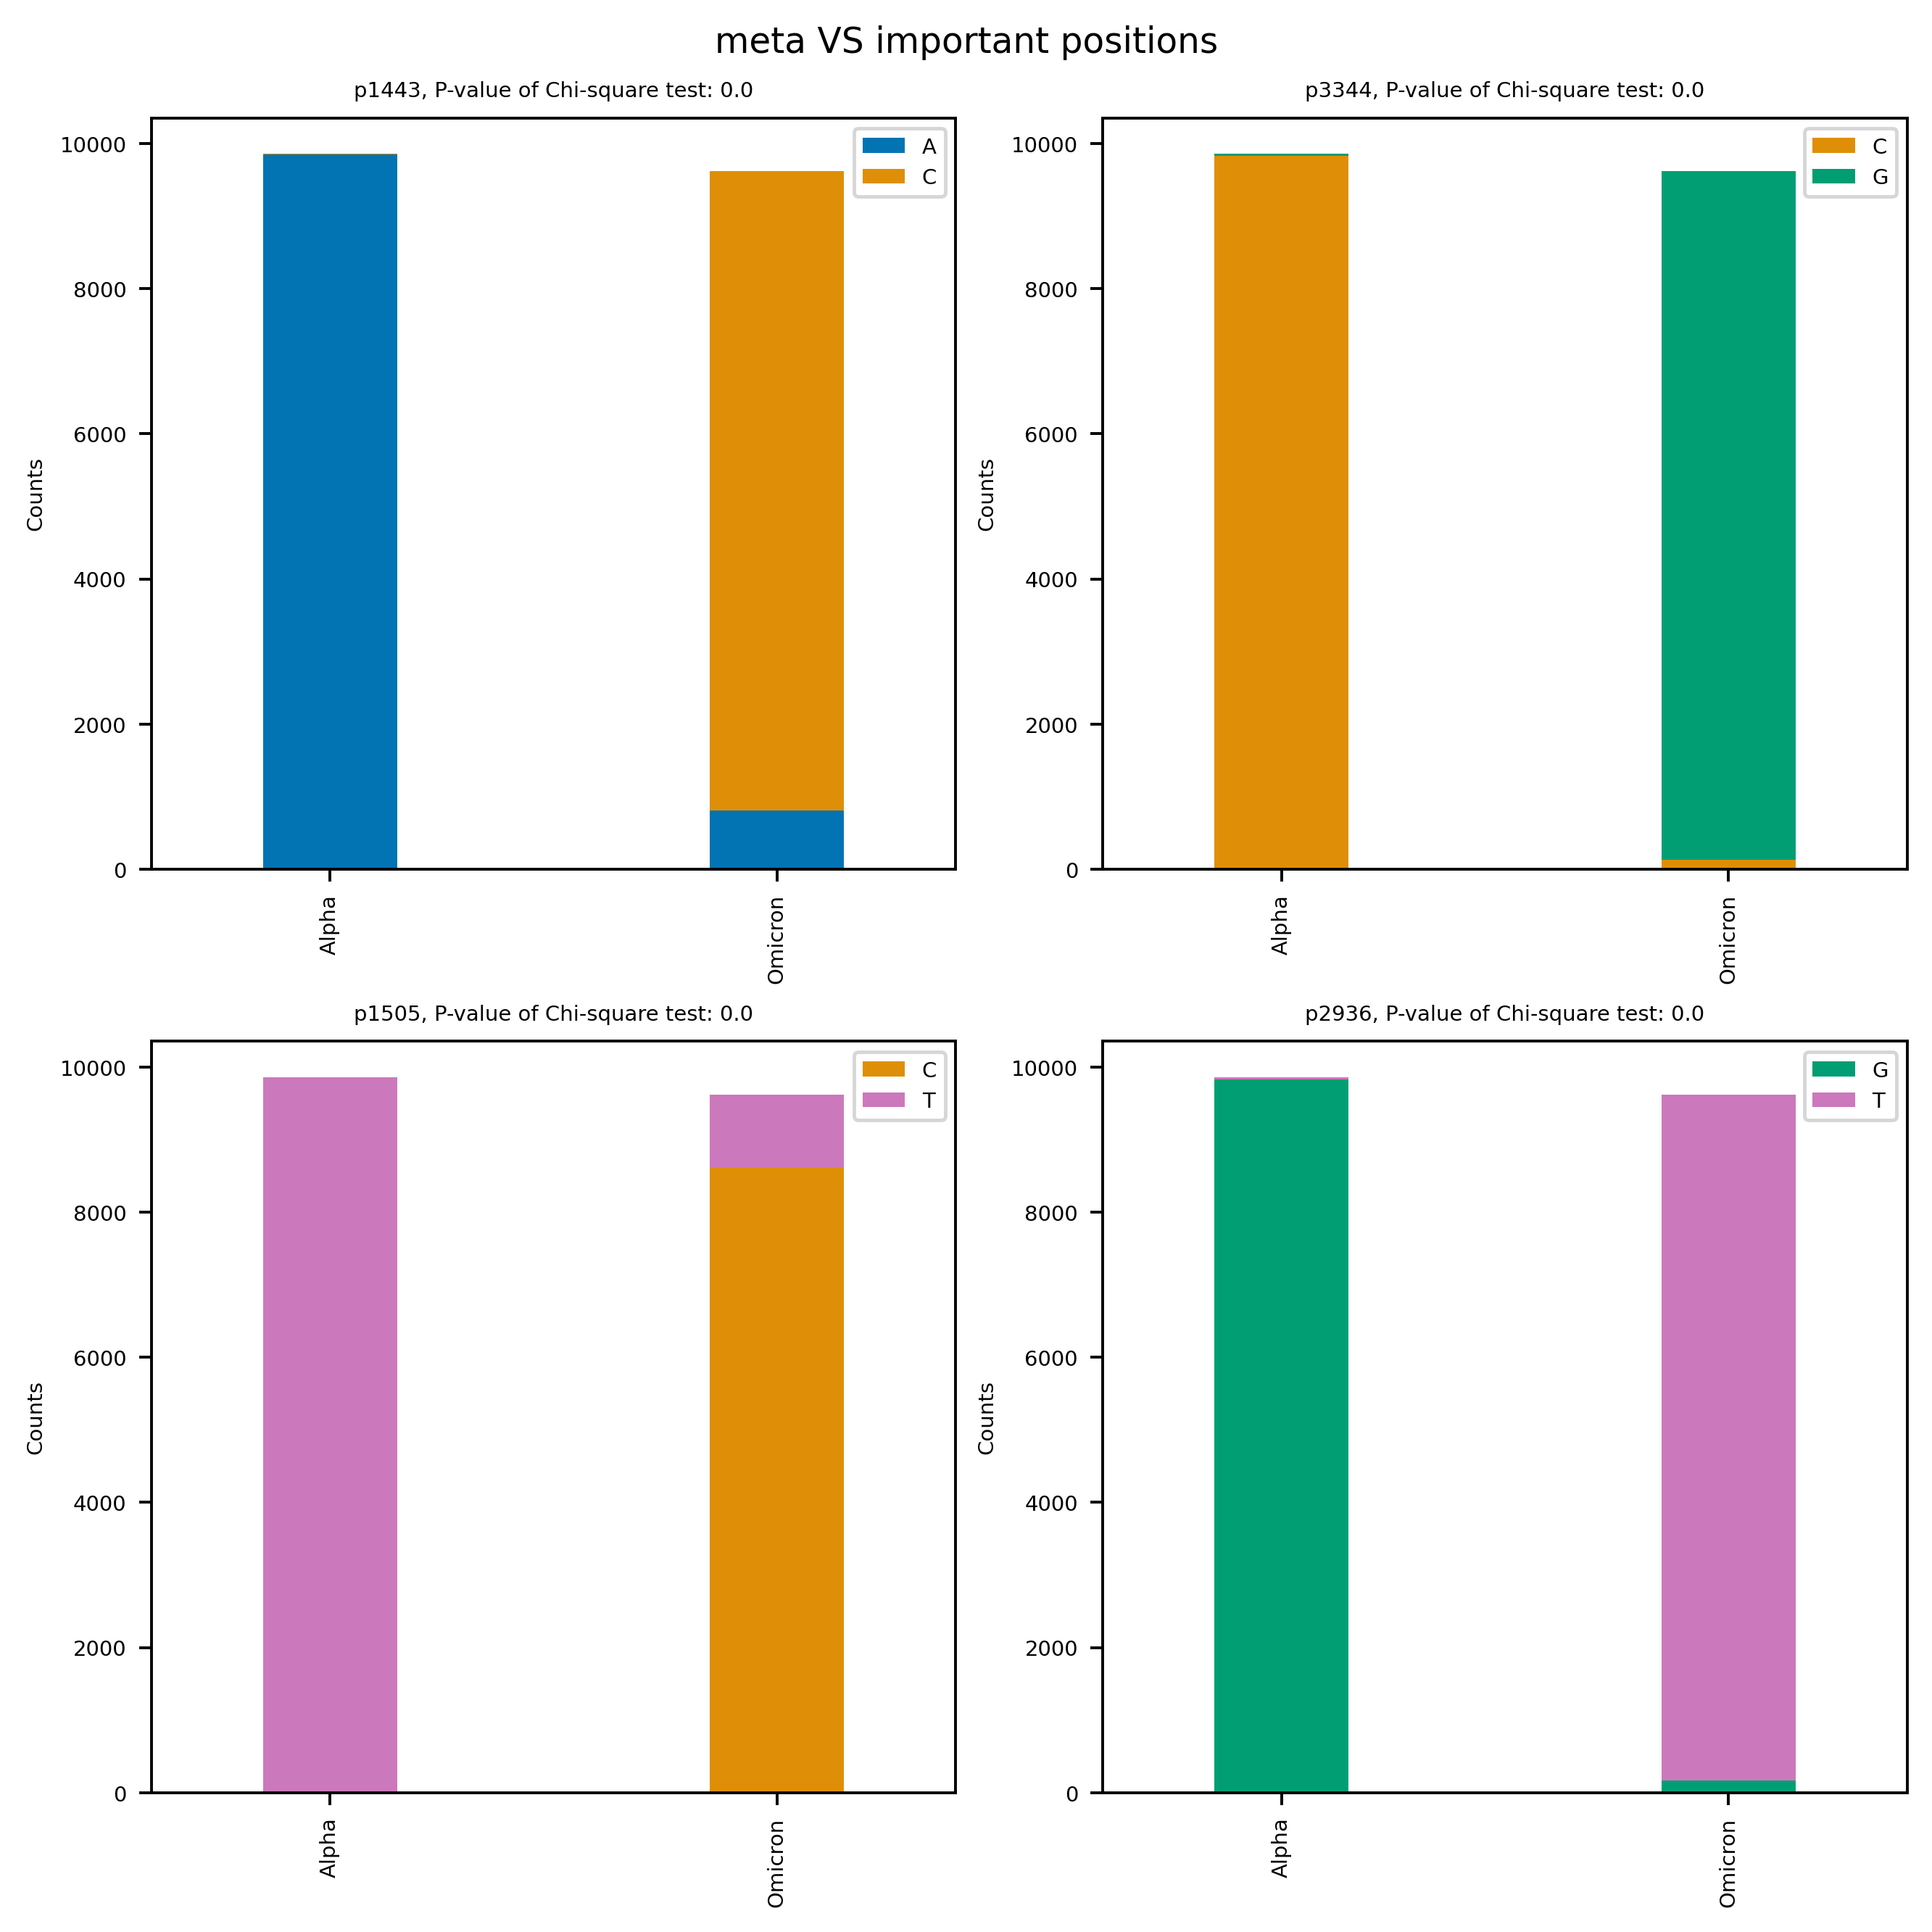

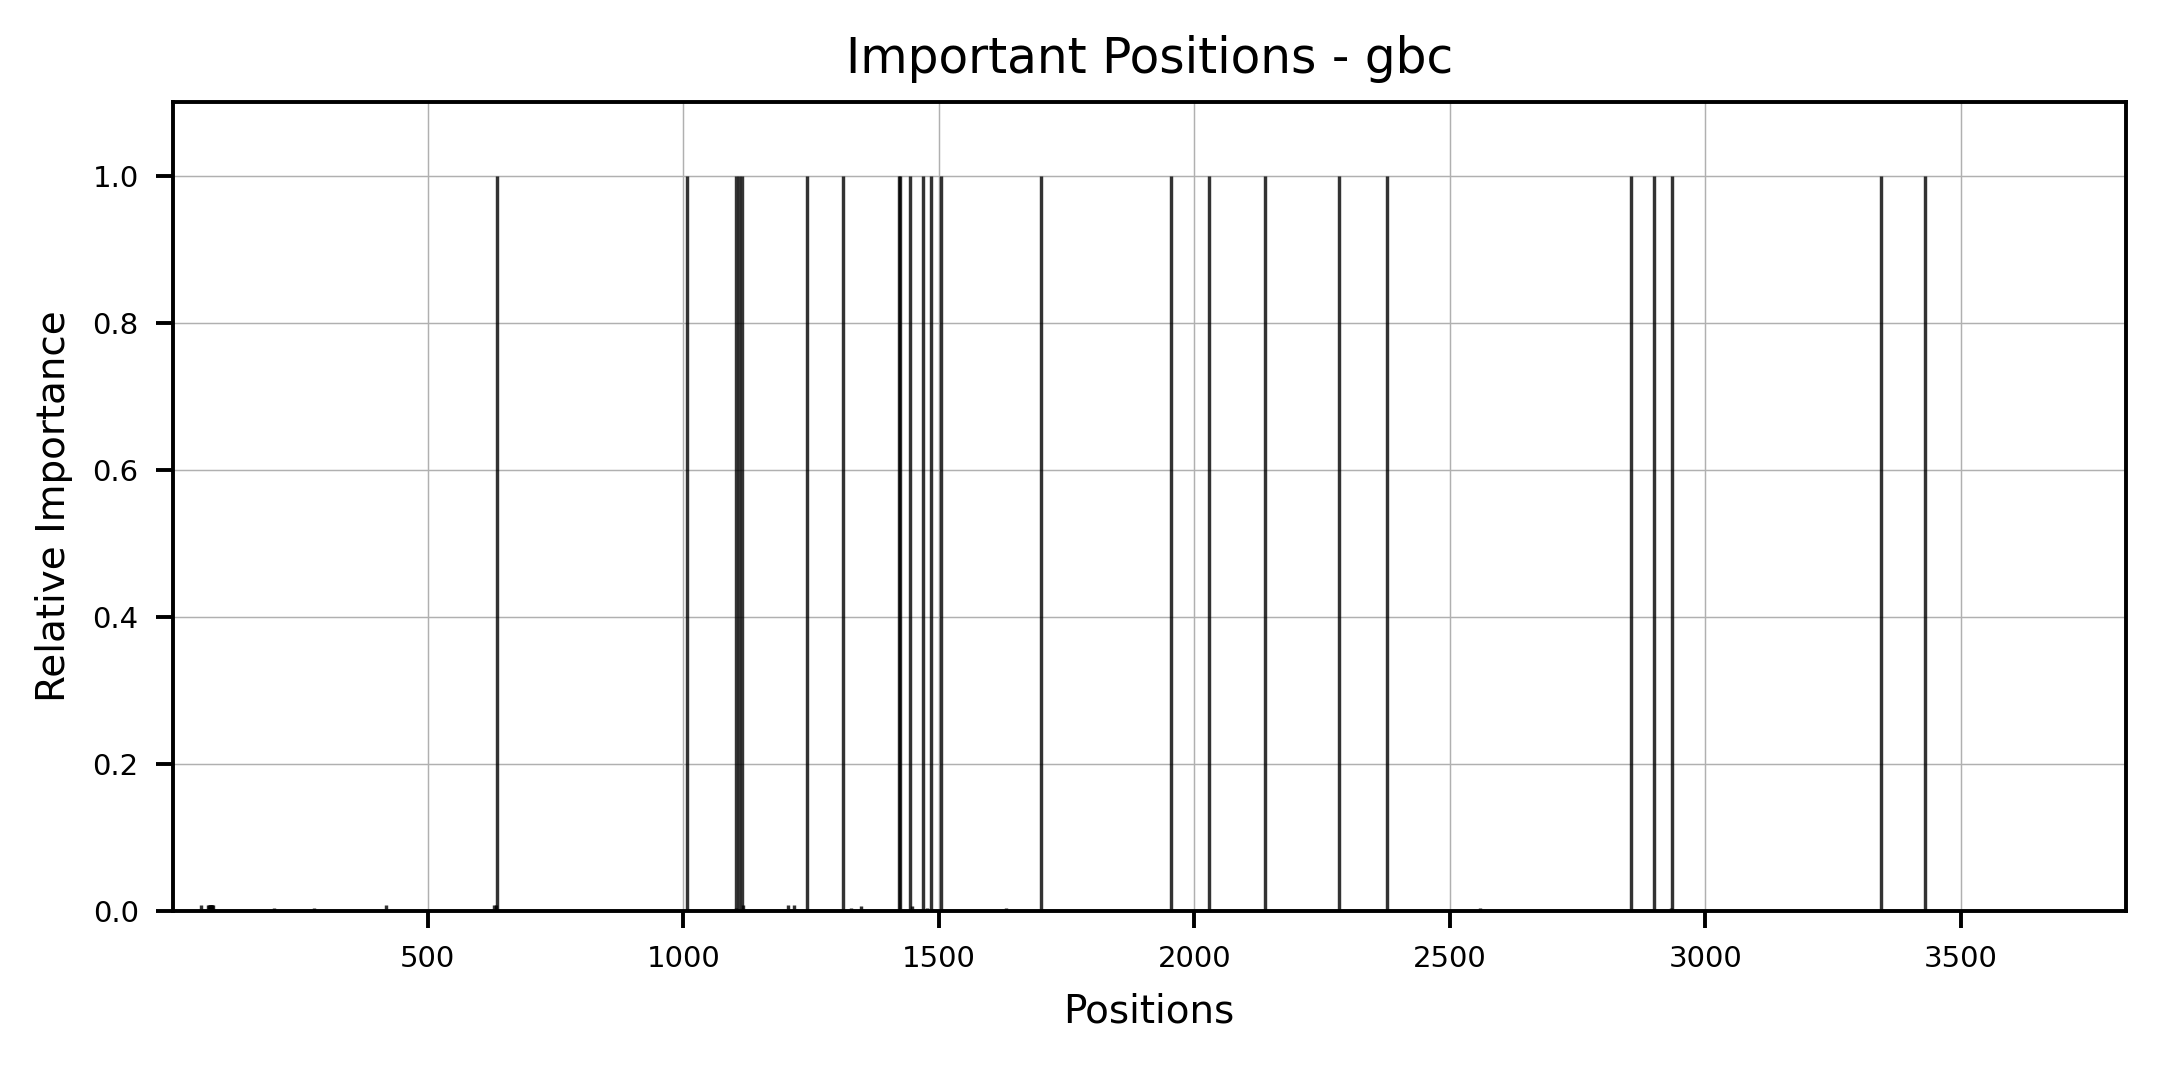

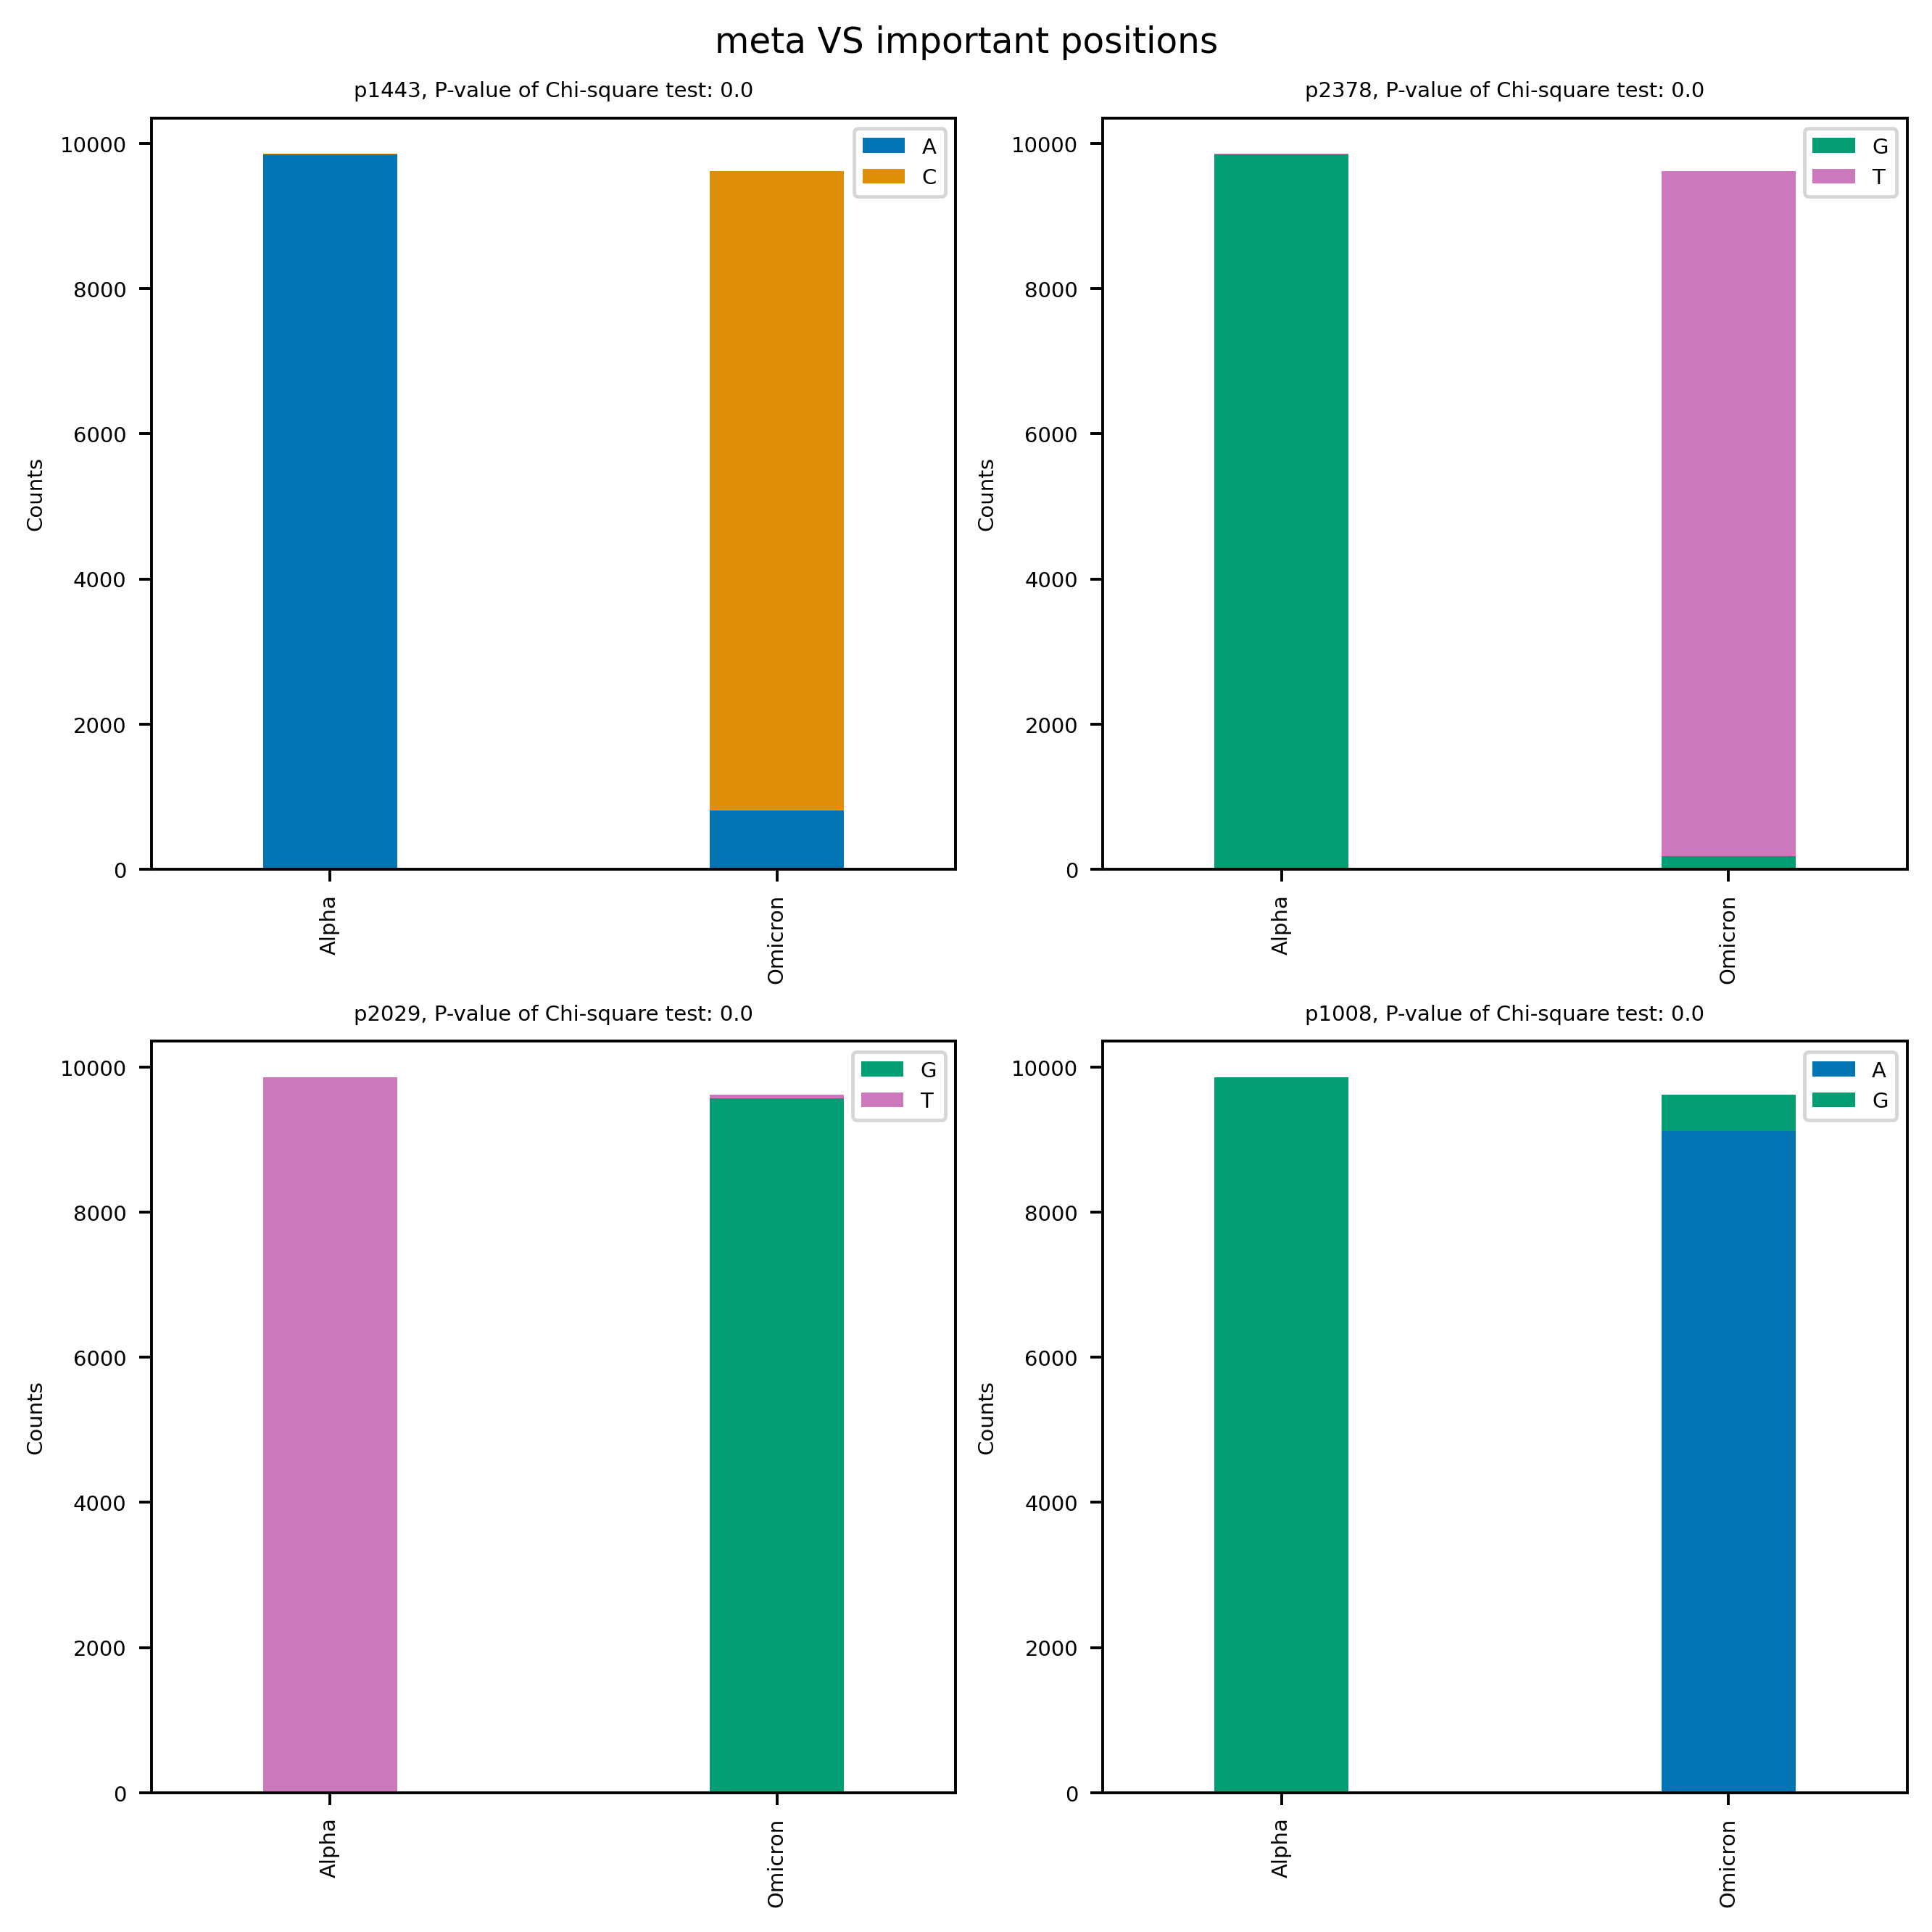

In [28]:
for model in top:
    model_name = model.steps[-1][0]
    dp_plot(importance=importance_from_pipe(model, aggregate_function='max'),
            imp_col='standard_value', annotate=0,
            model_name = model_name, report_dir=report_dir)
    
    plot_imp_model(importance=importance_from_pipe(model, aggregate_function='max'),
                   X_train=tr, y_train=y, model_name=model_name,
                   meta_var='meta', model_type=ana_type, report_dir=report_dir)

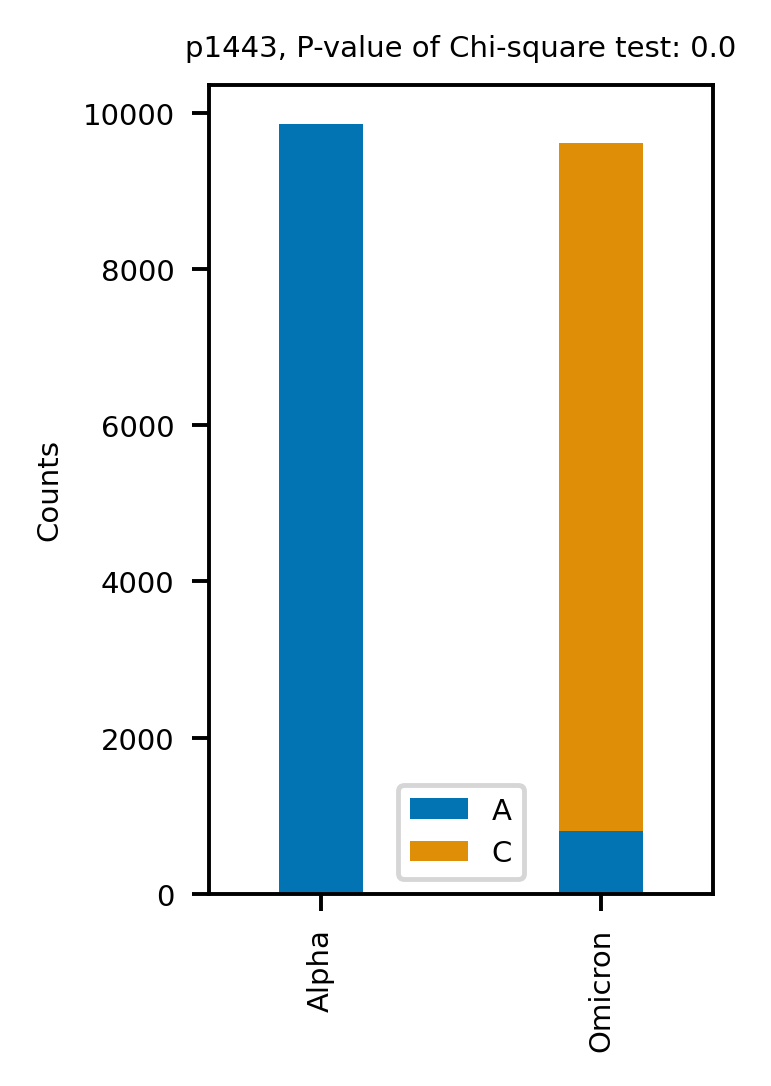

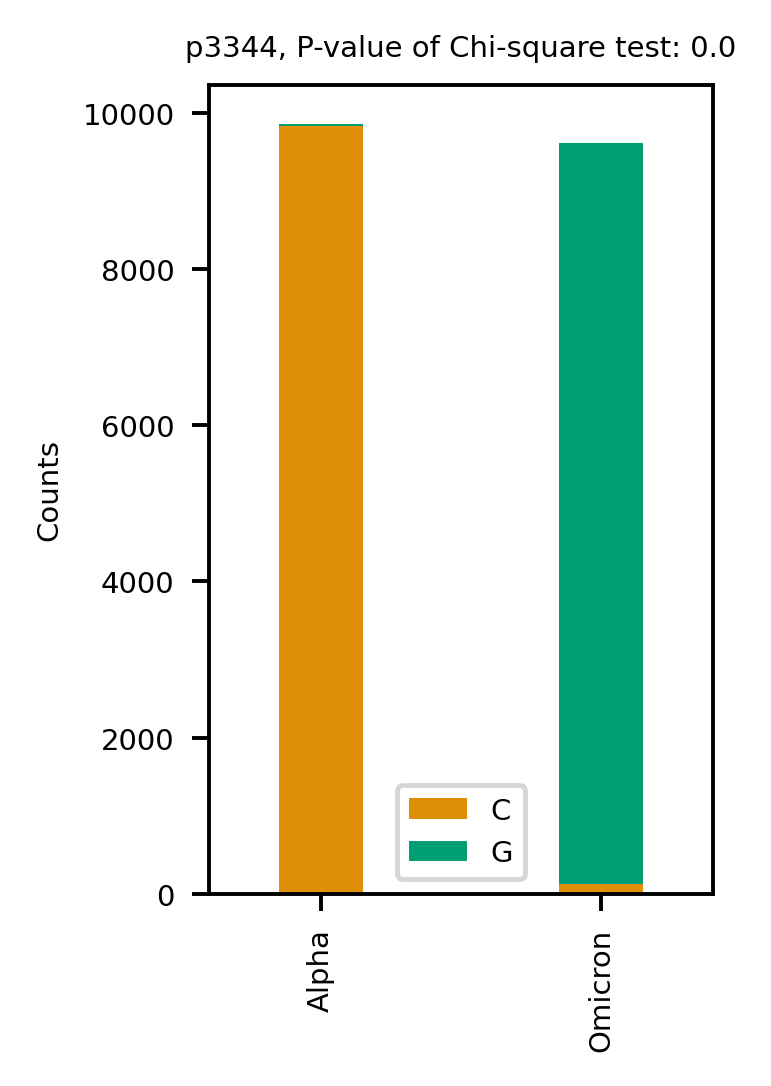

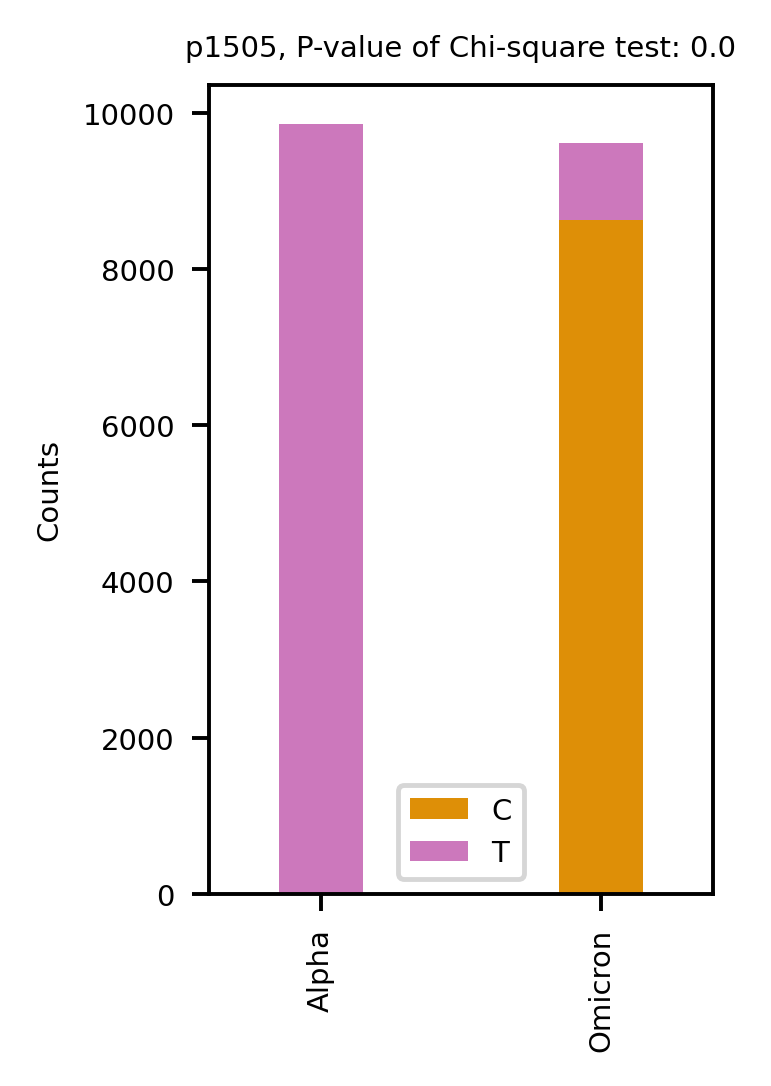

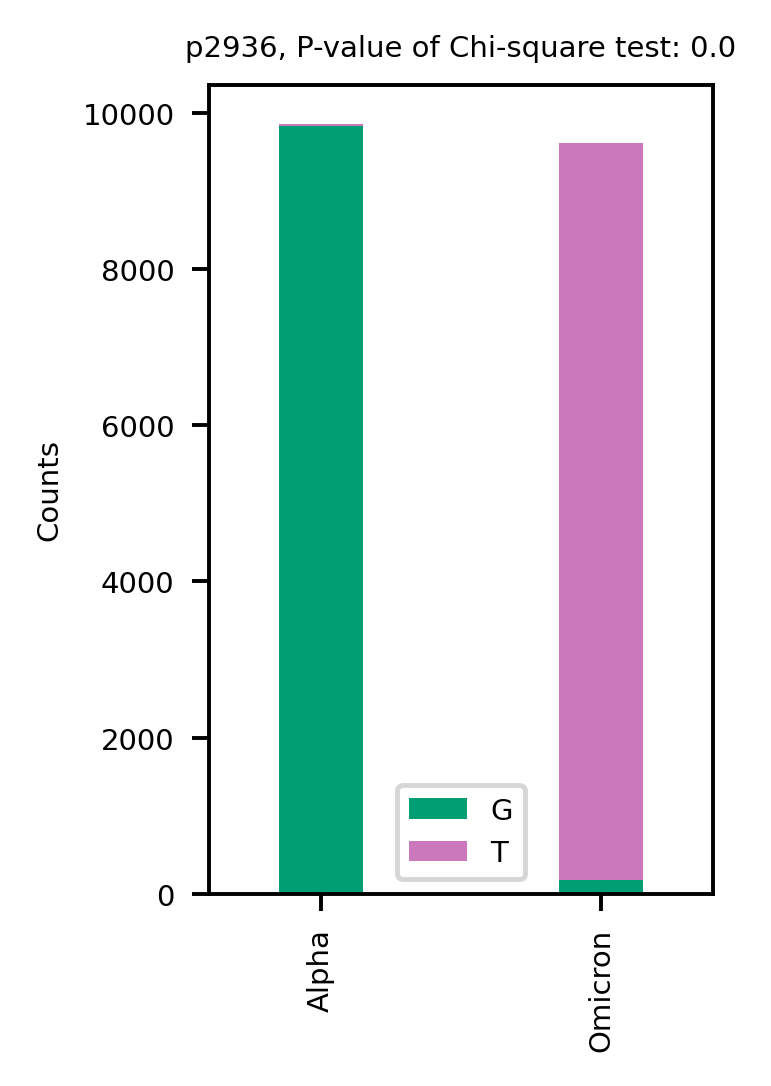

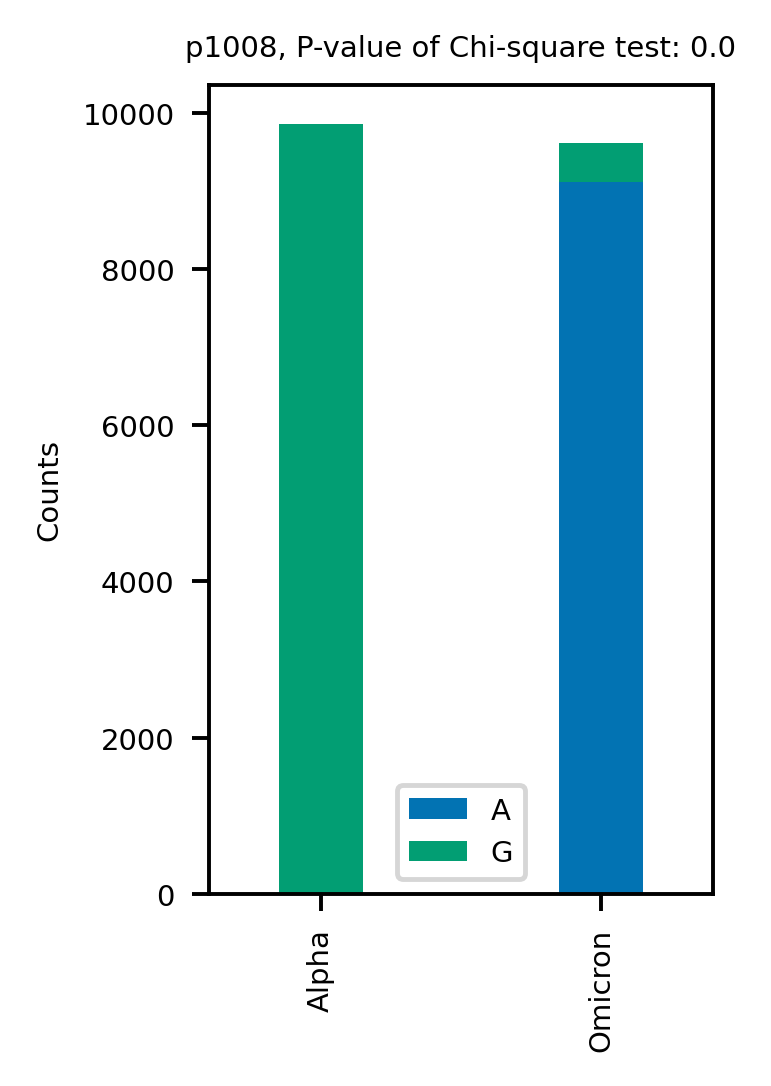

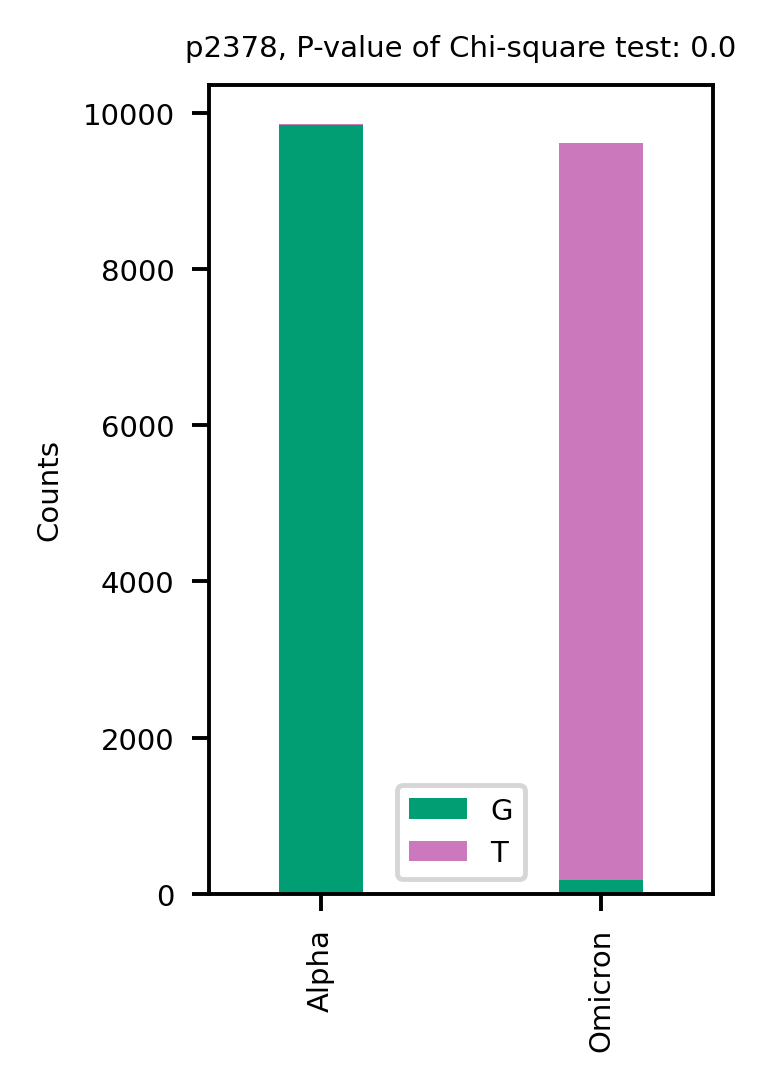

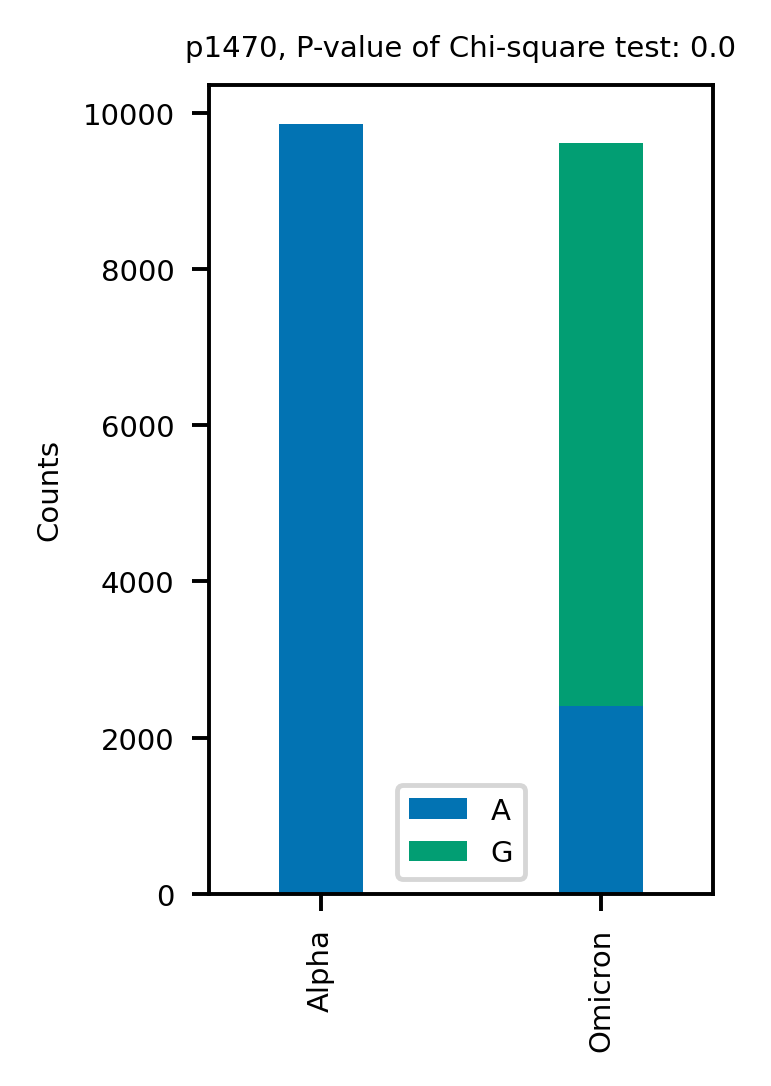

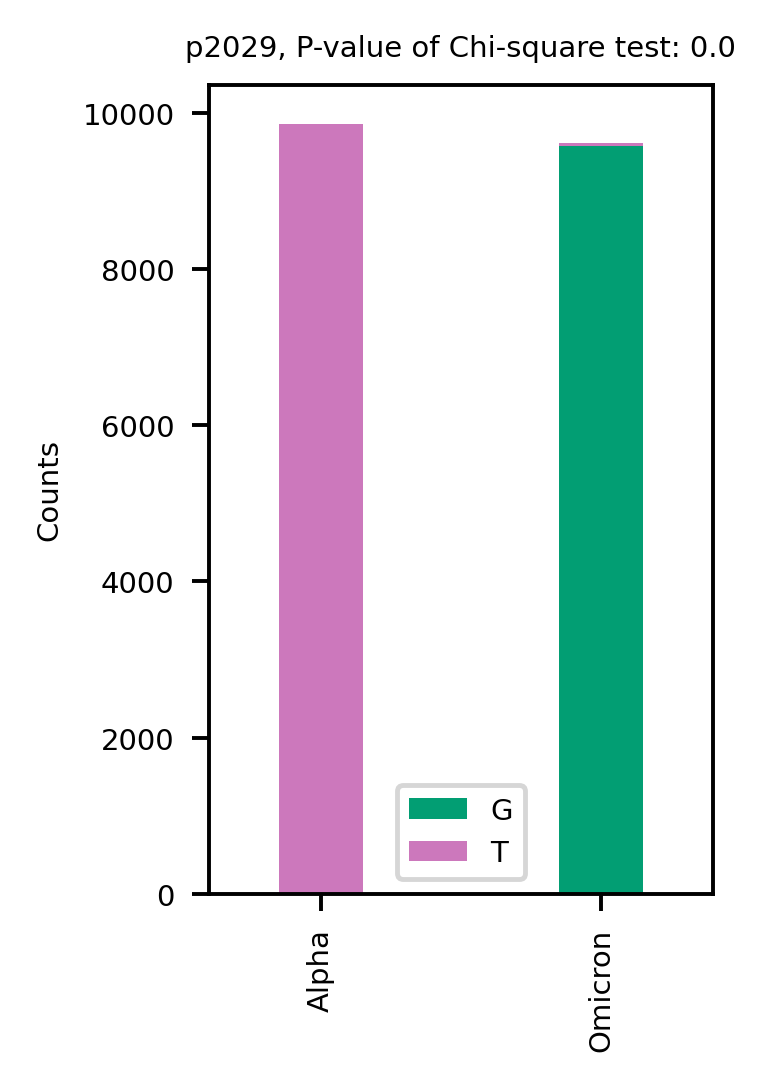

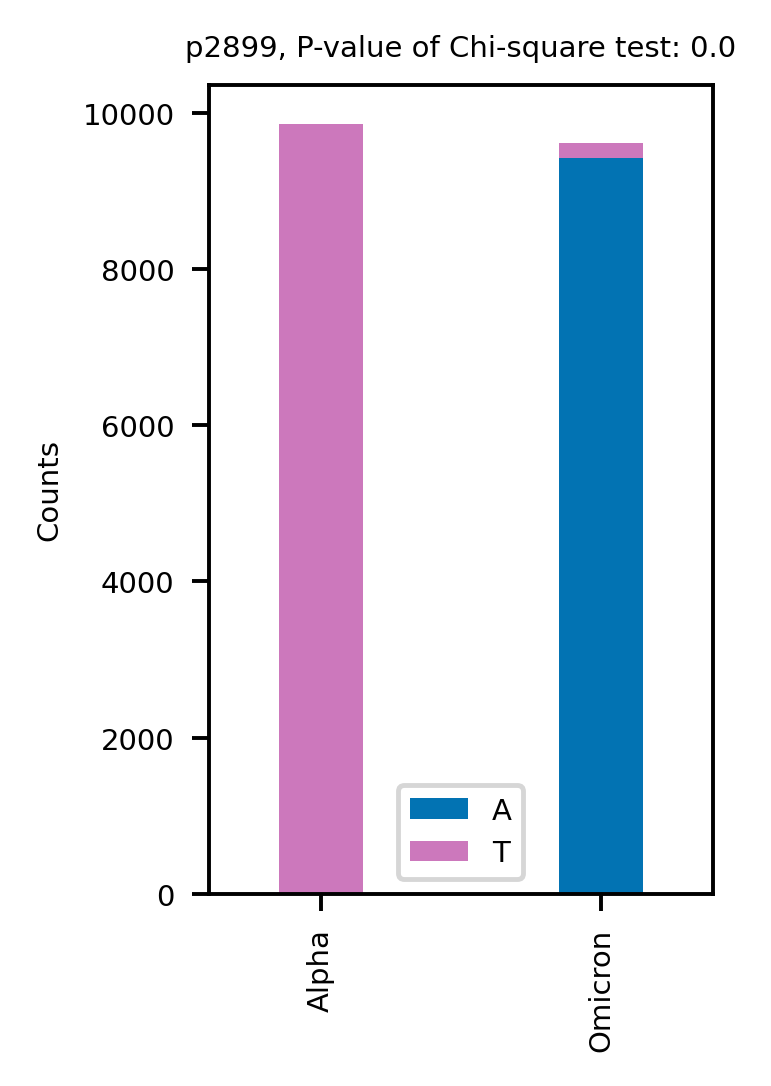

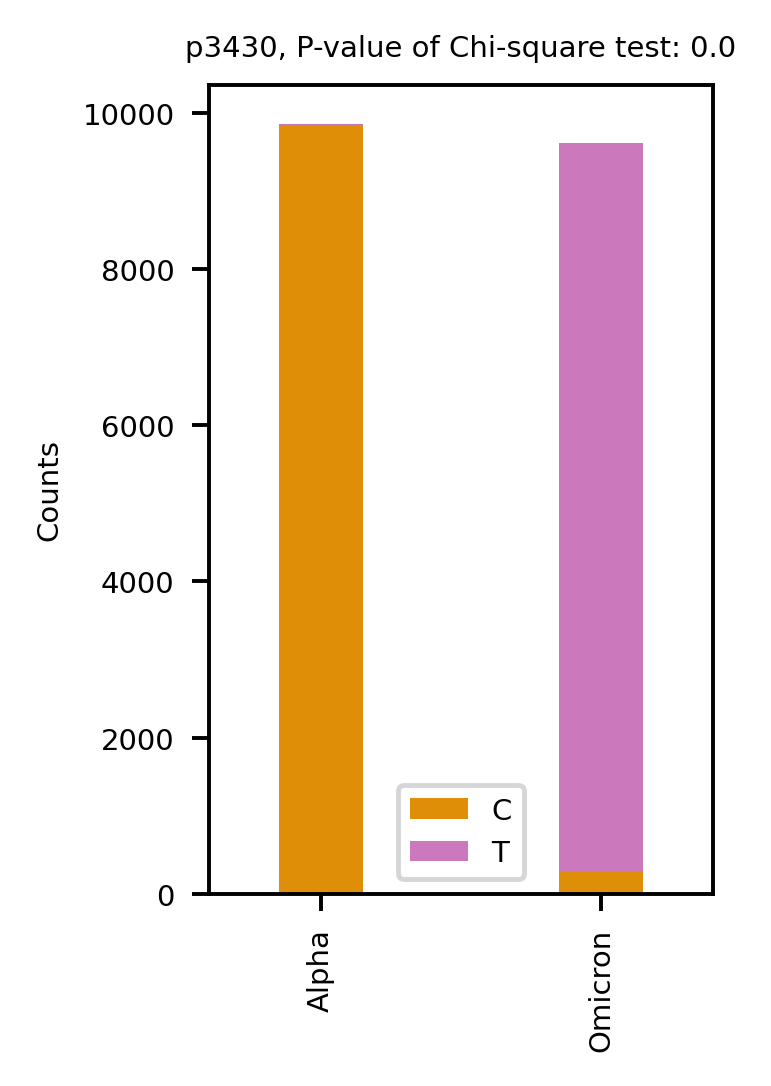

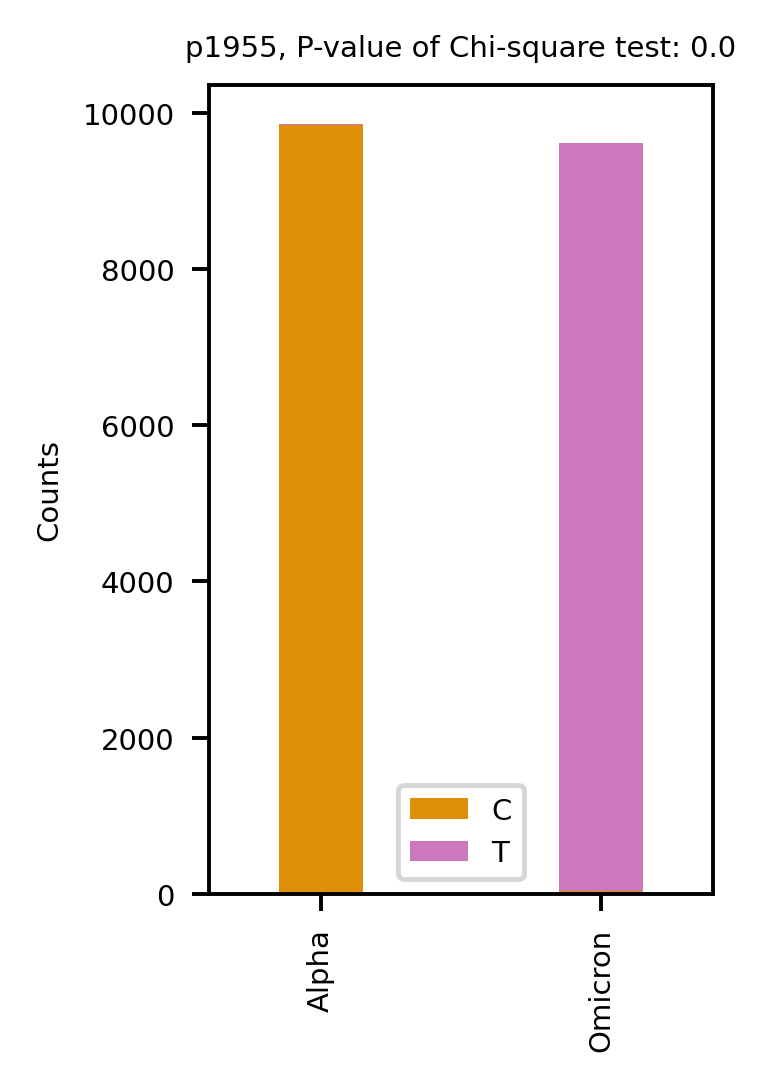

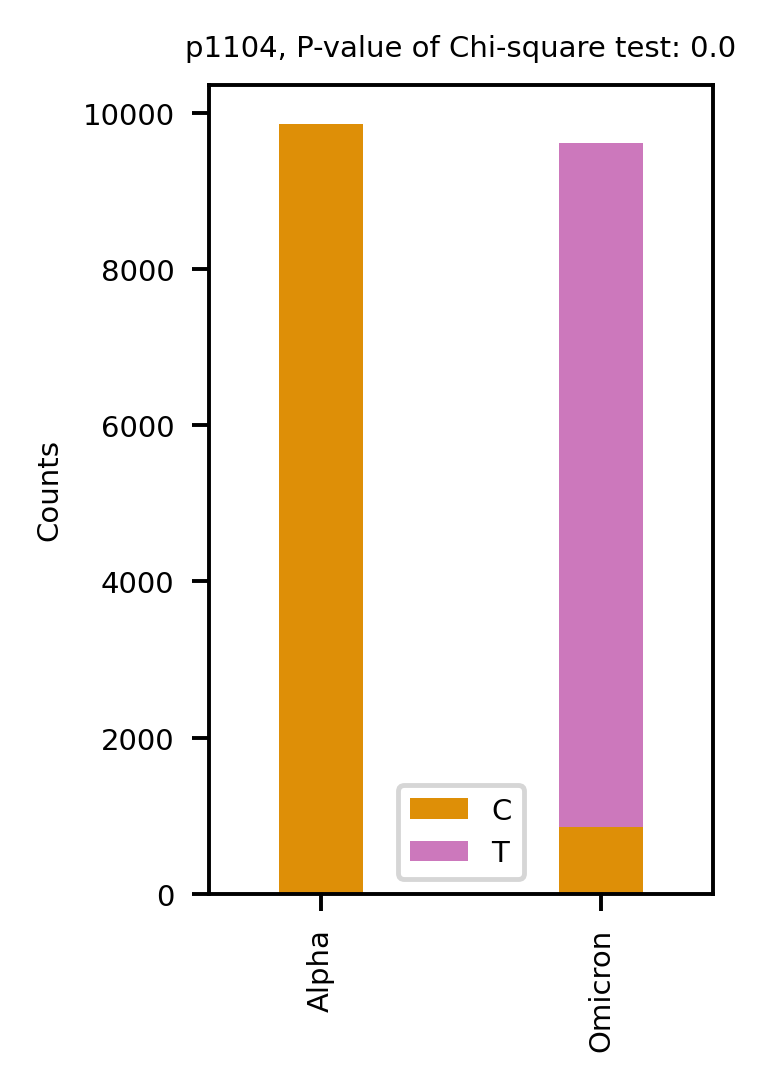

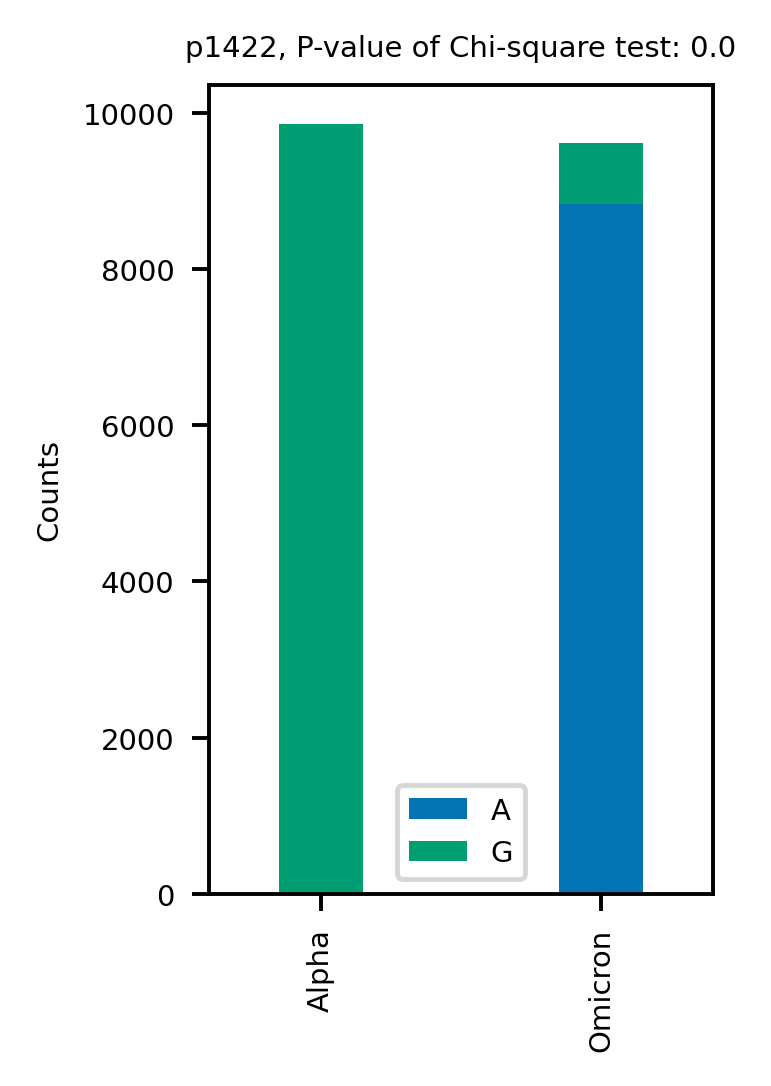

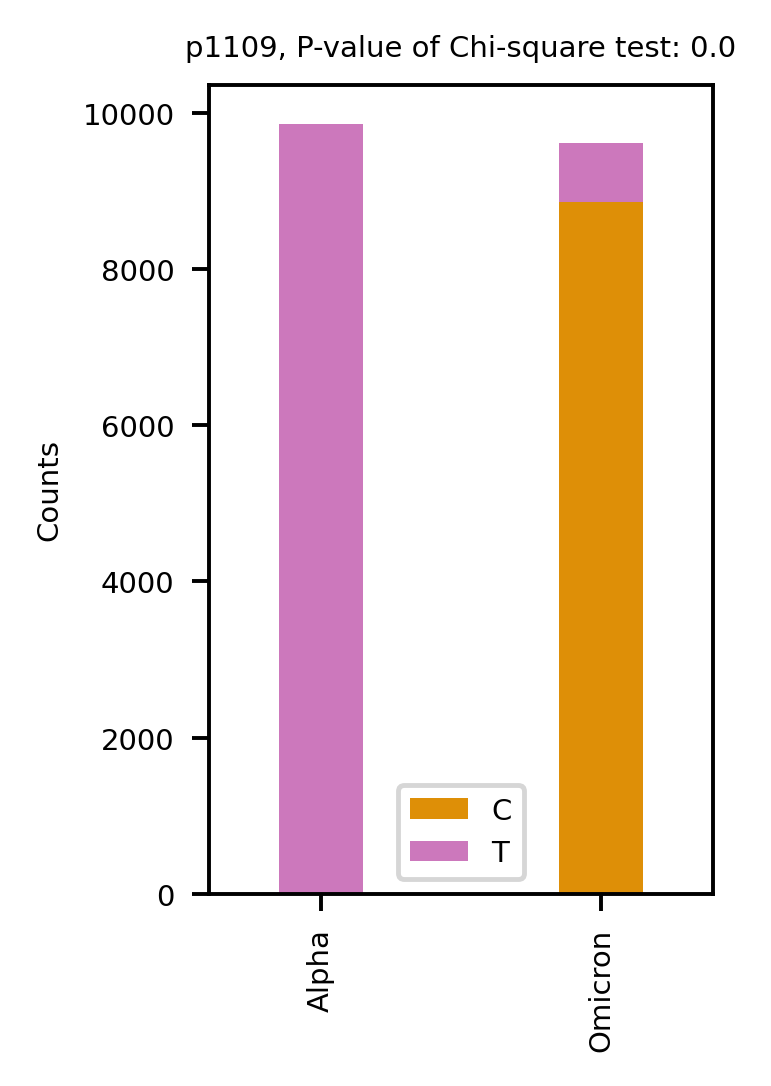

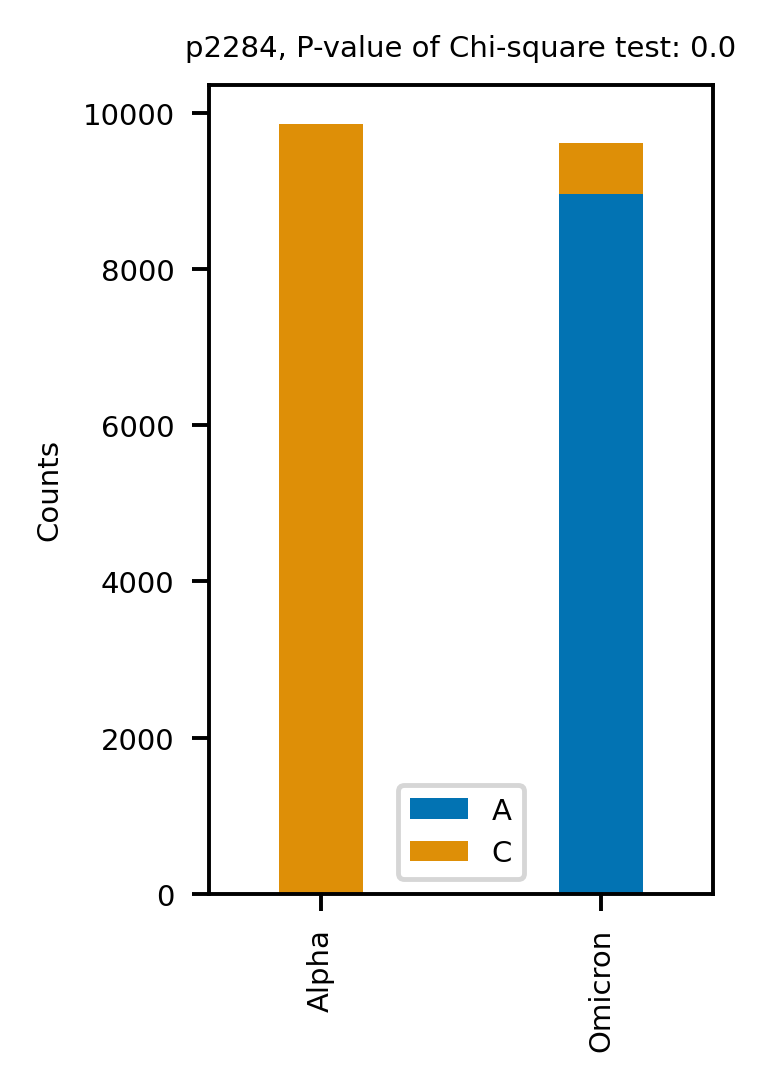

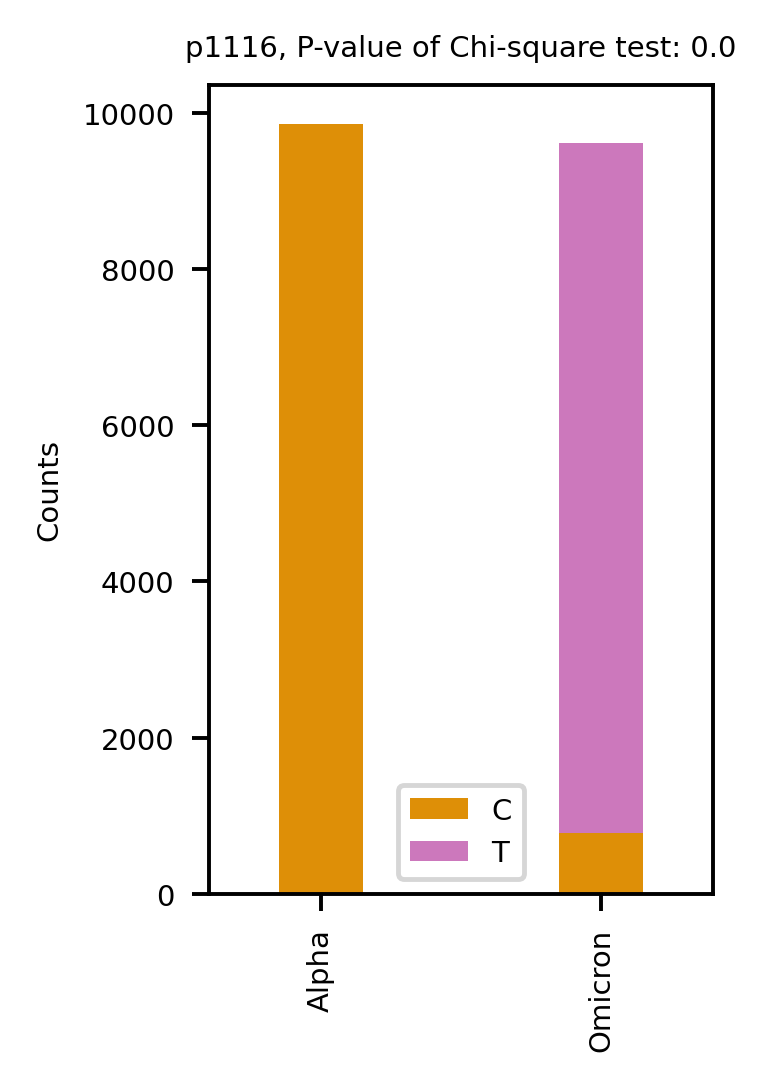

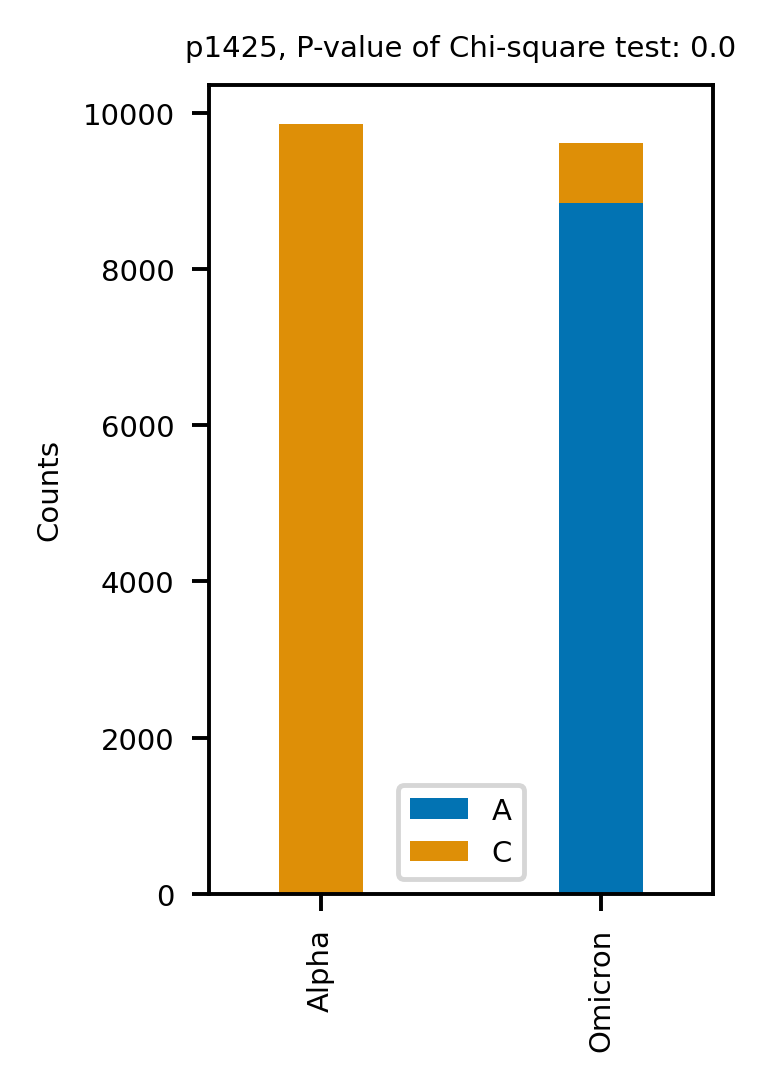

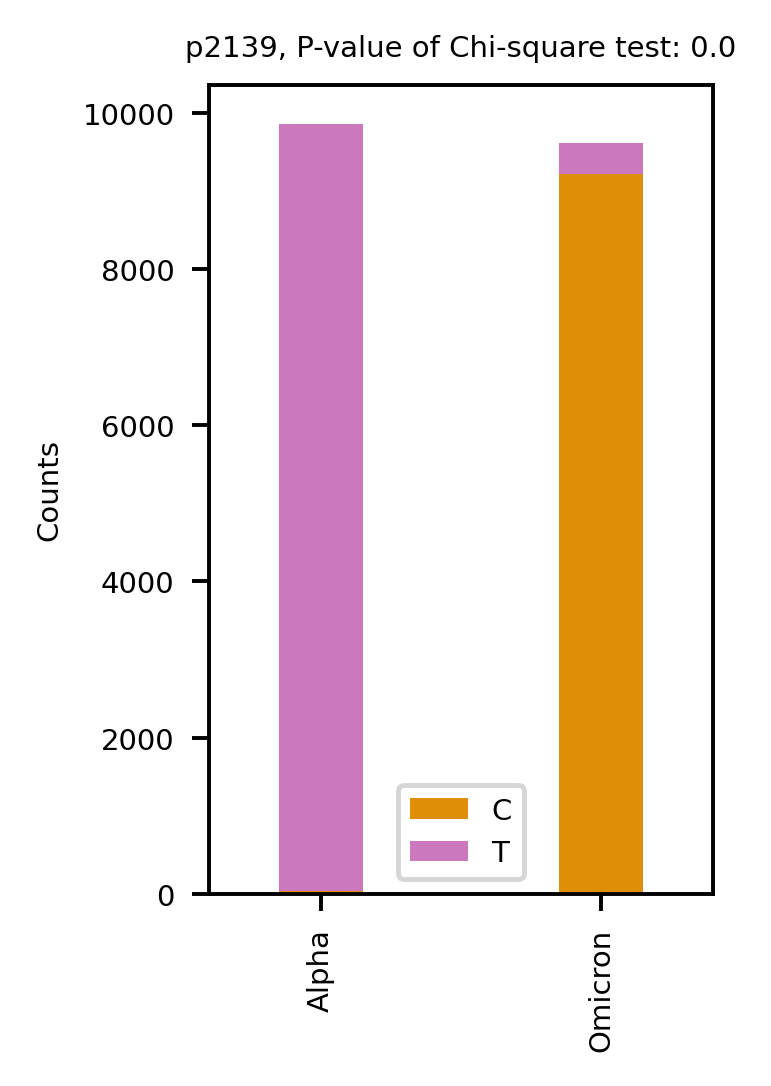

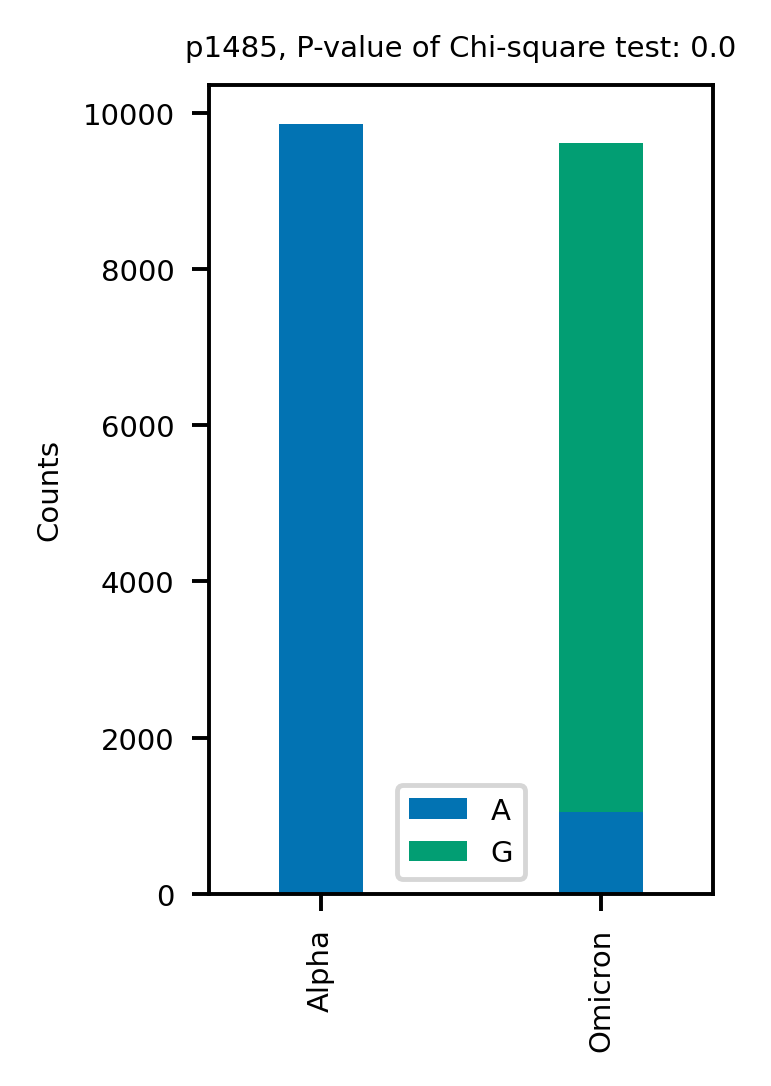

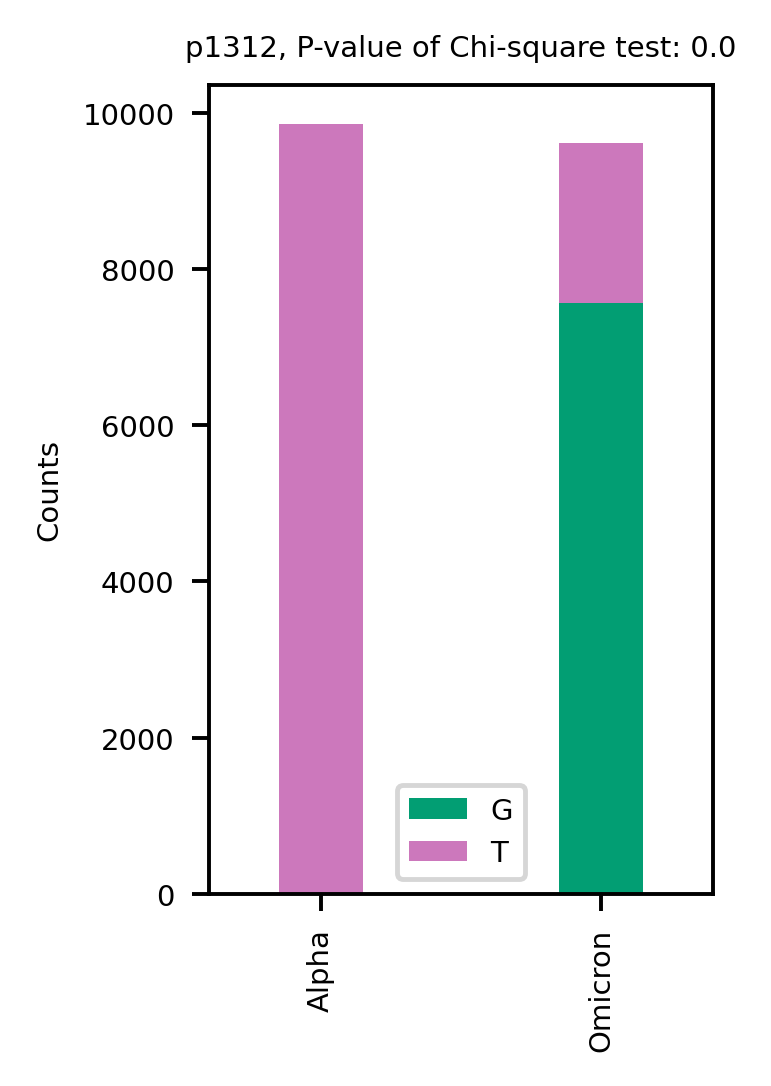

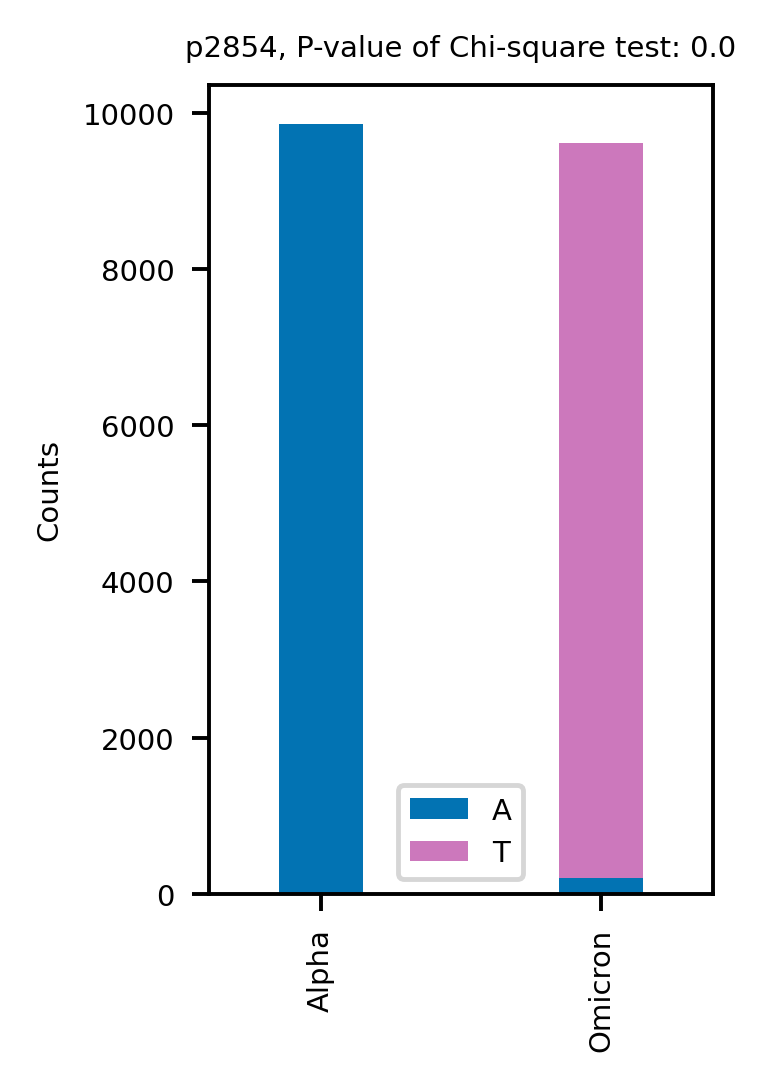

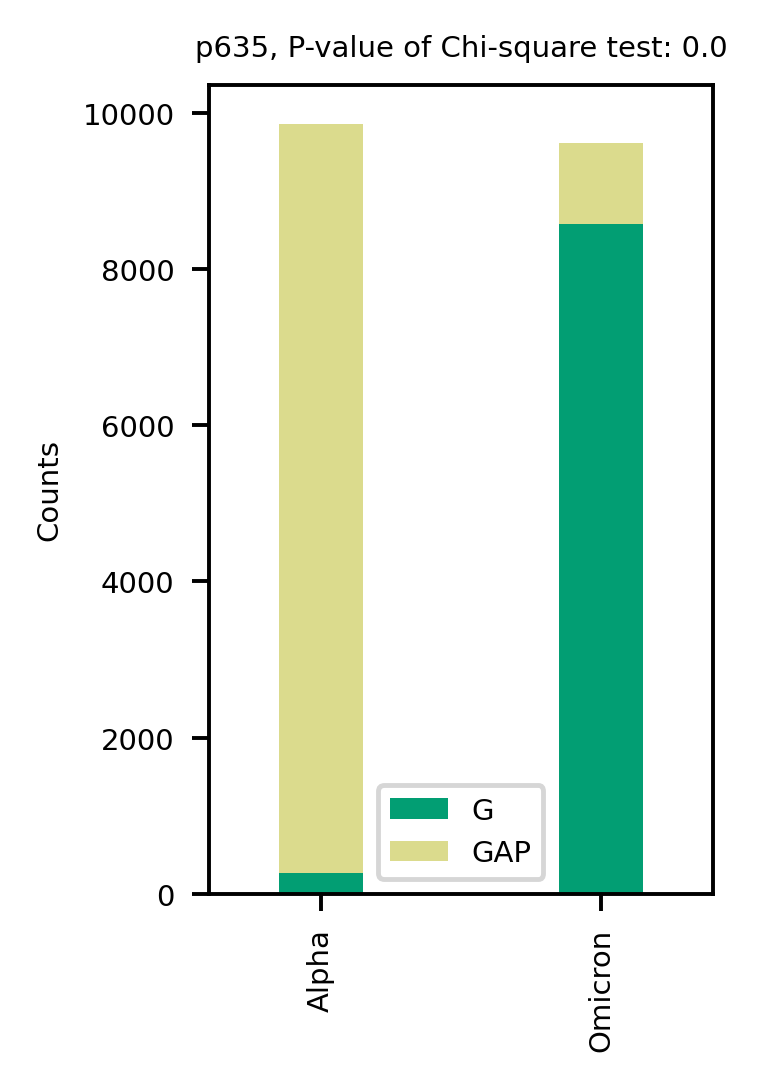

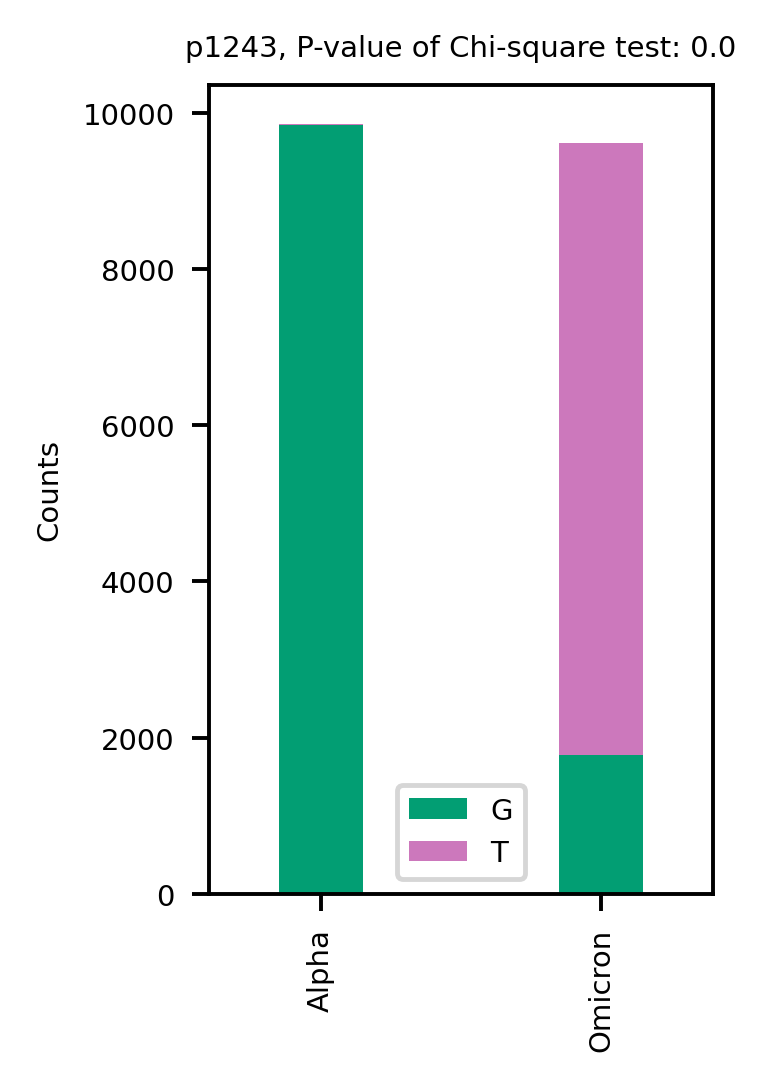

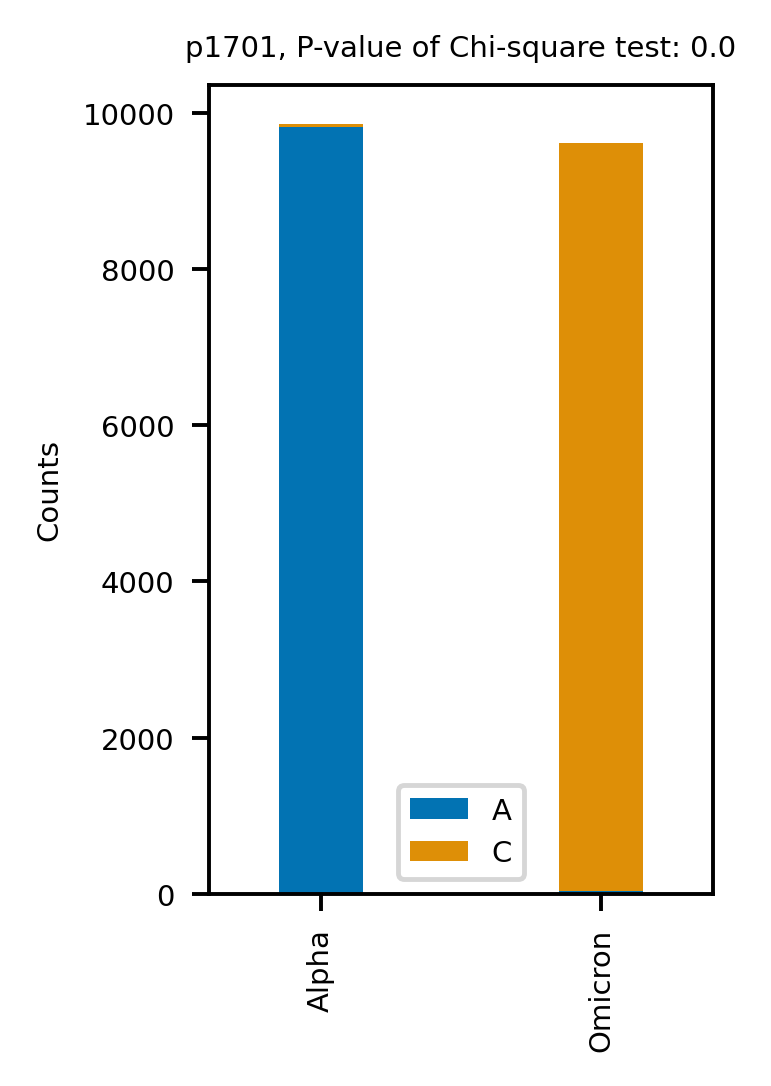

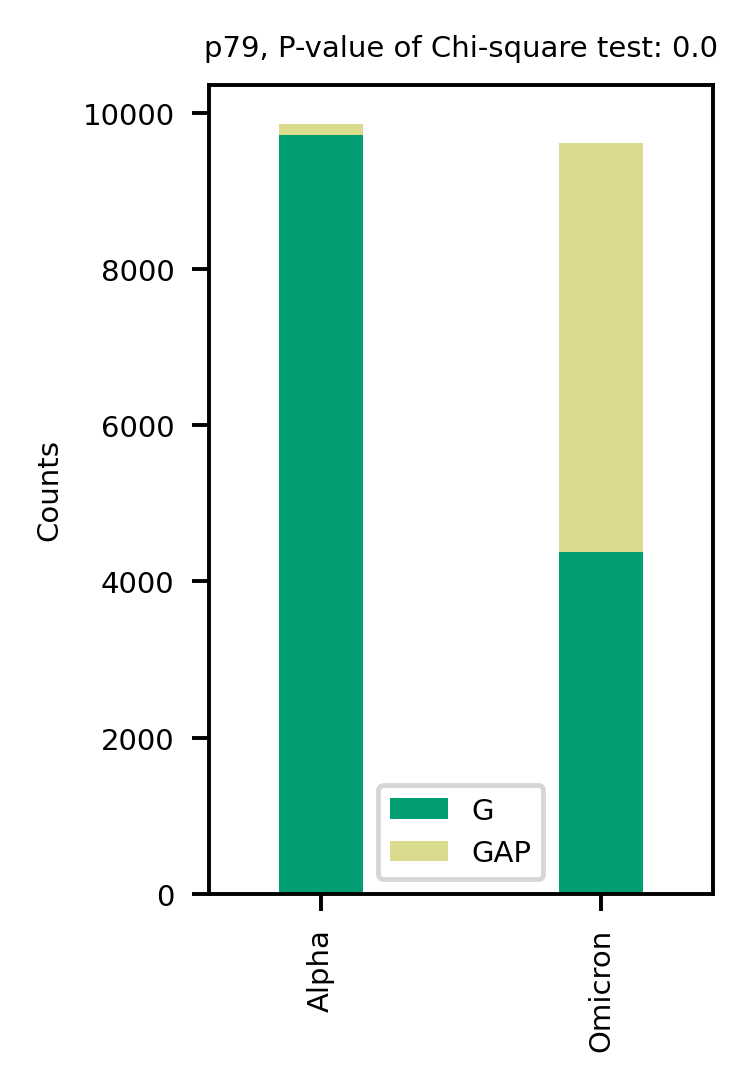

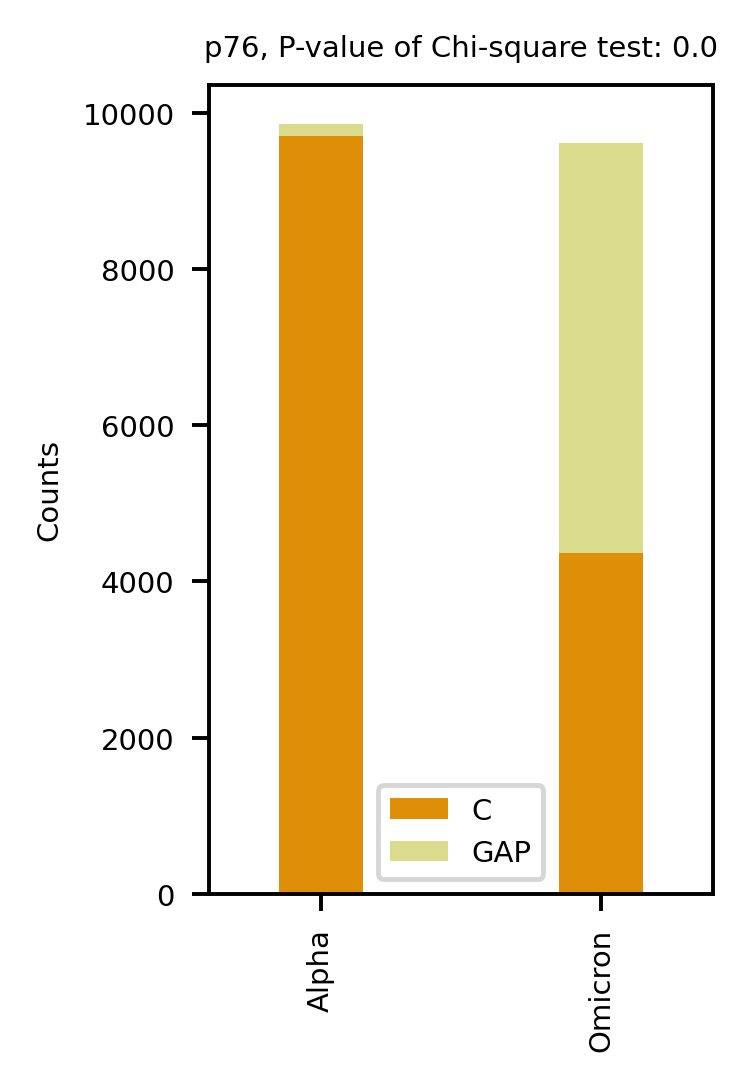

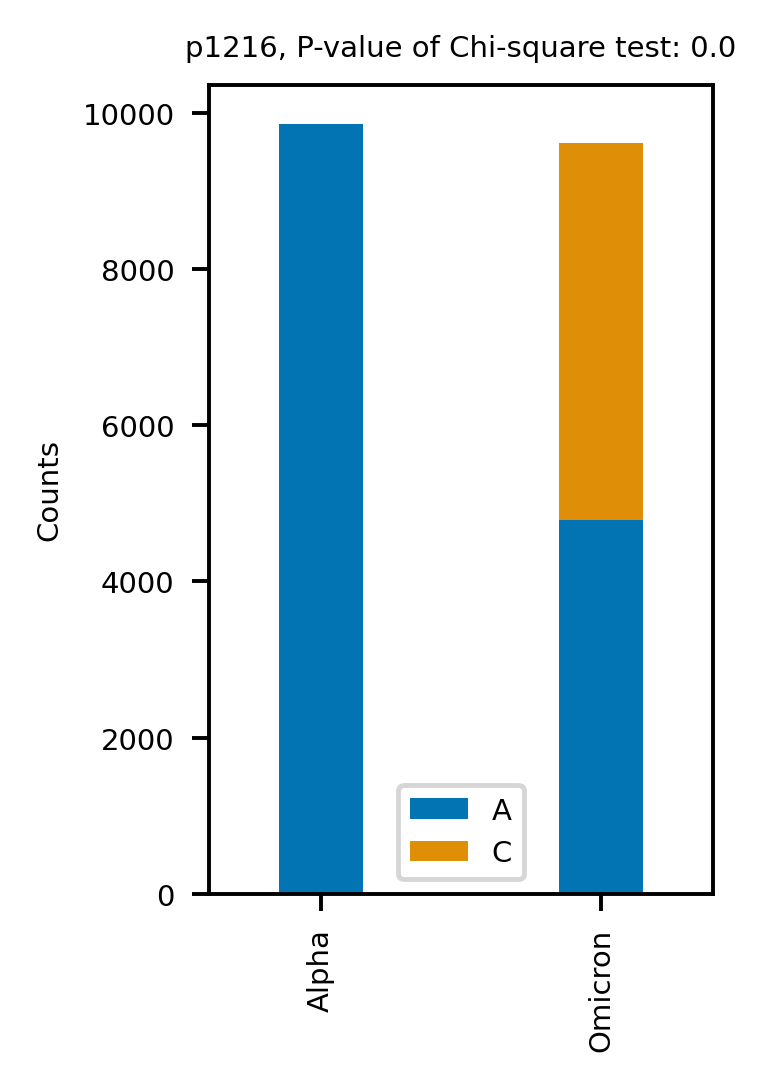

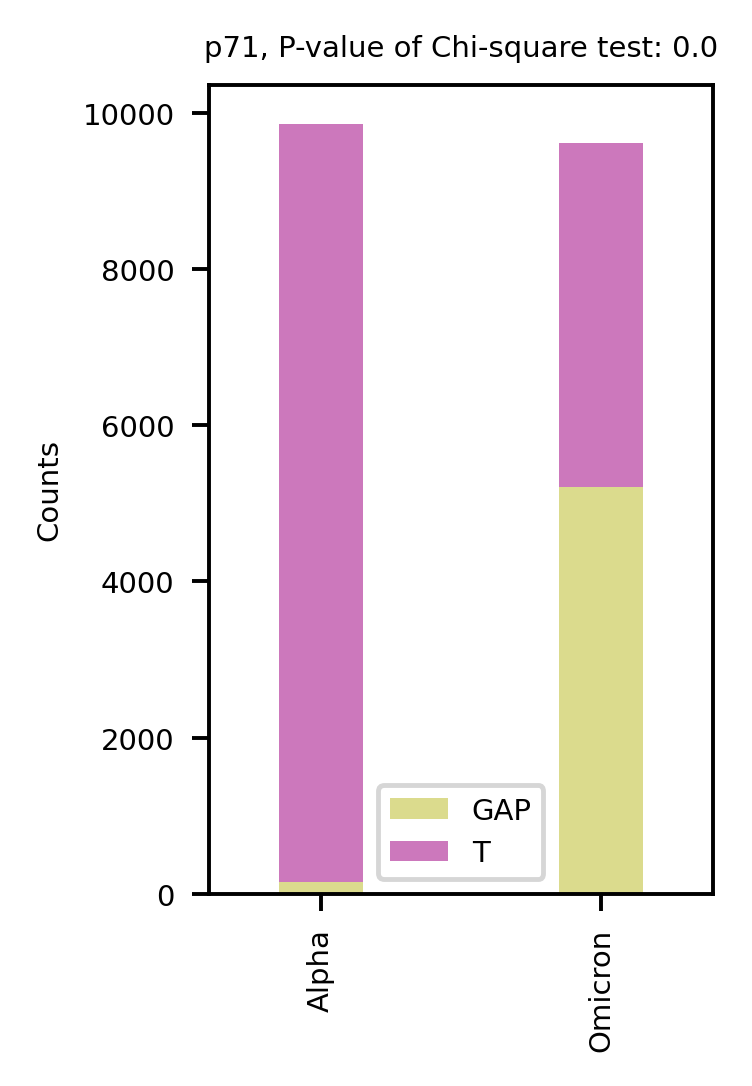

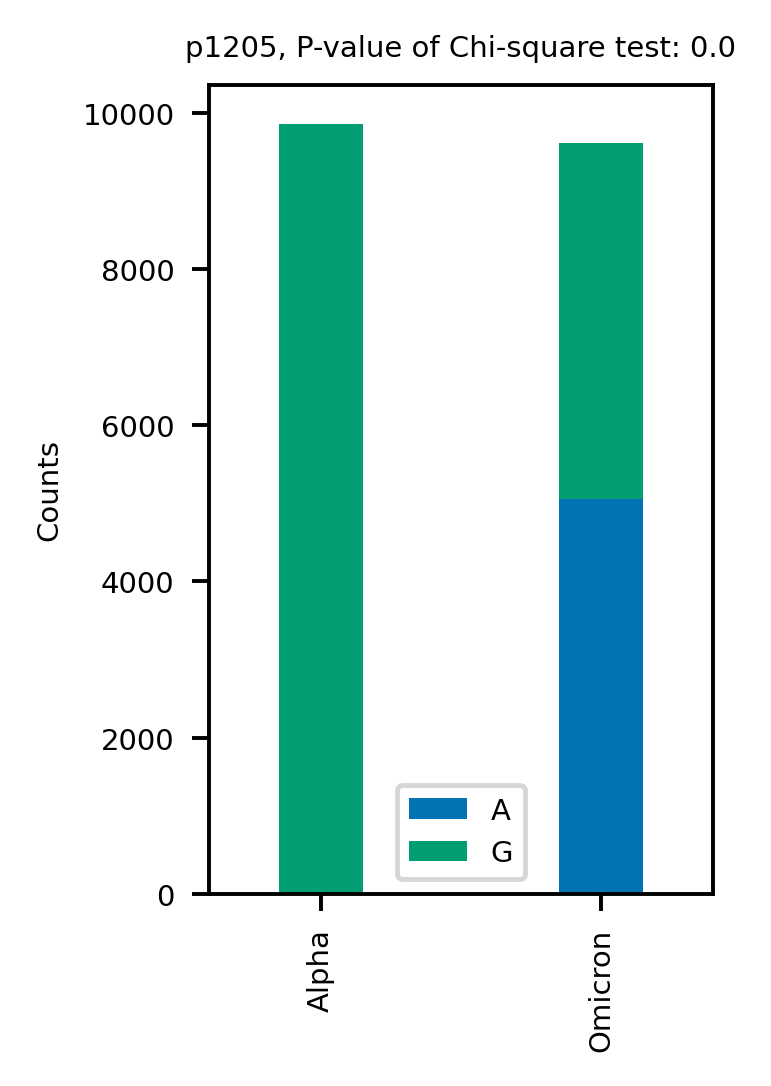

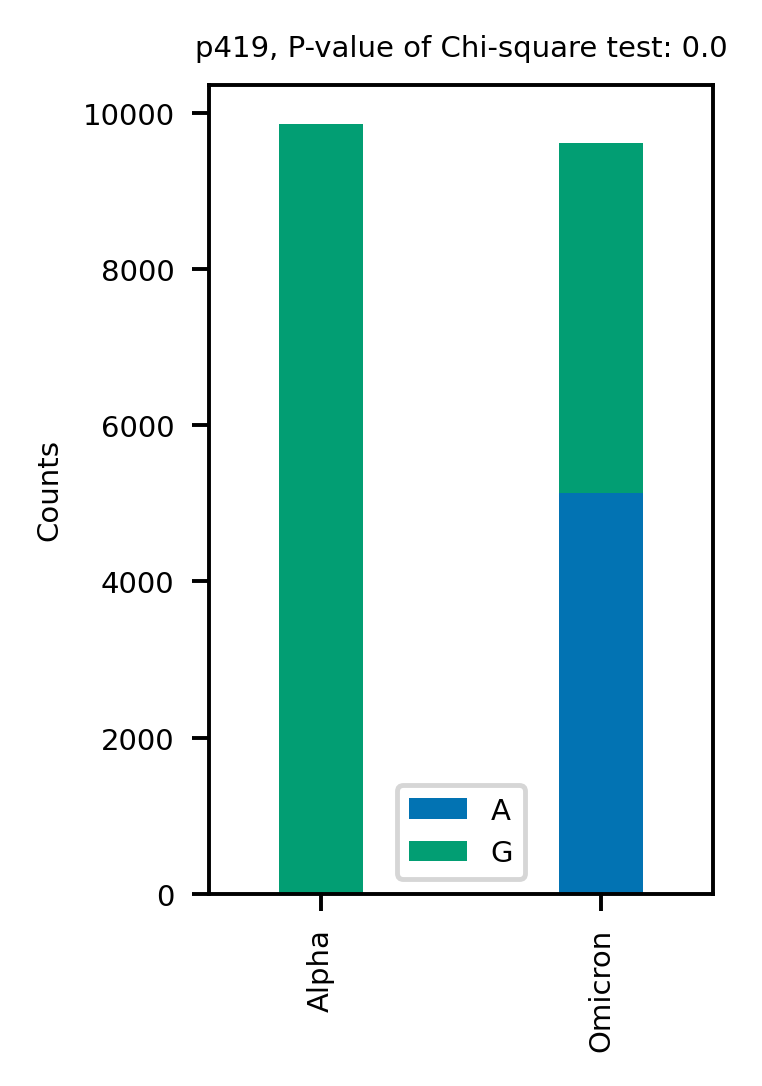

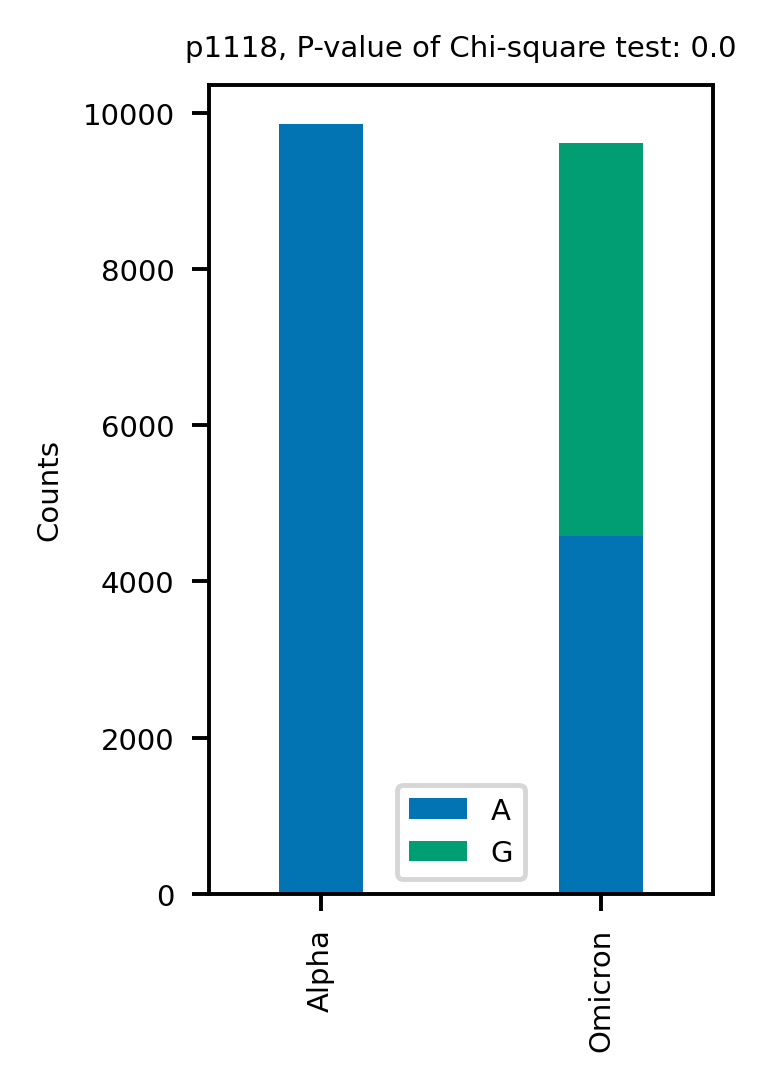

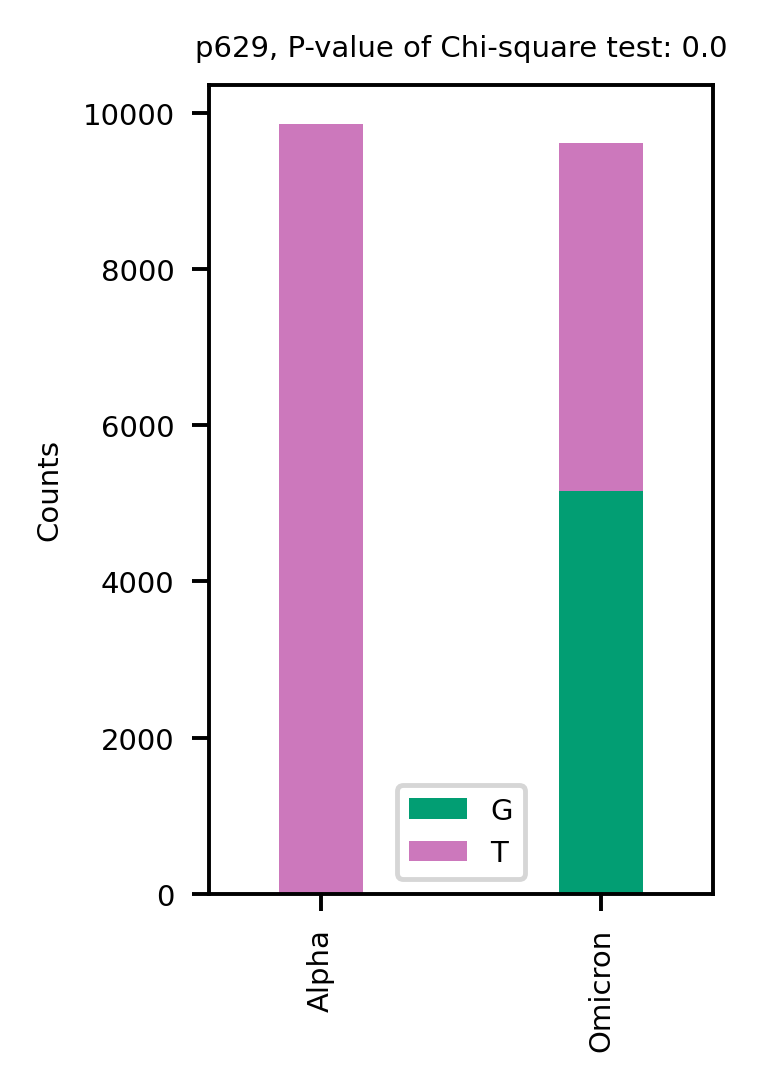

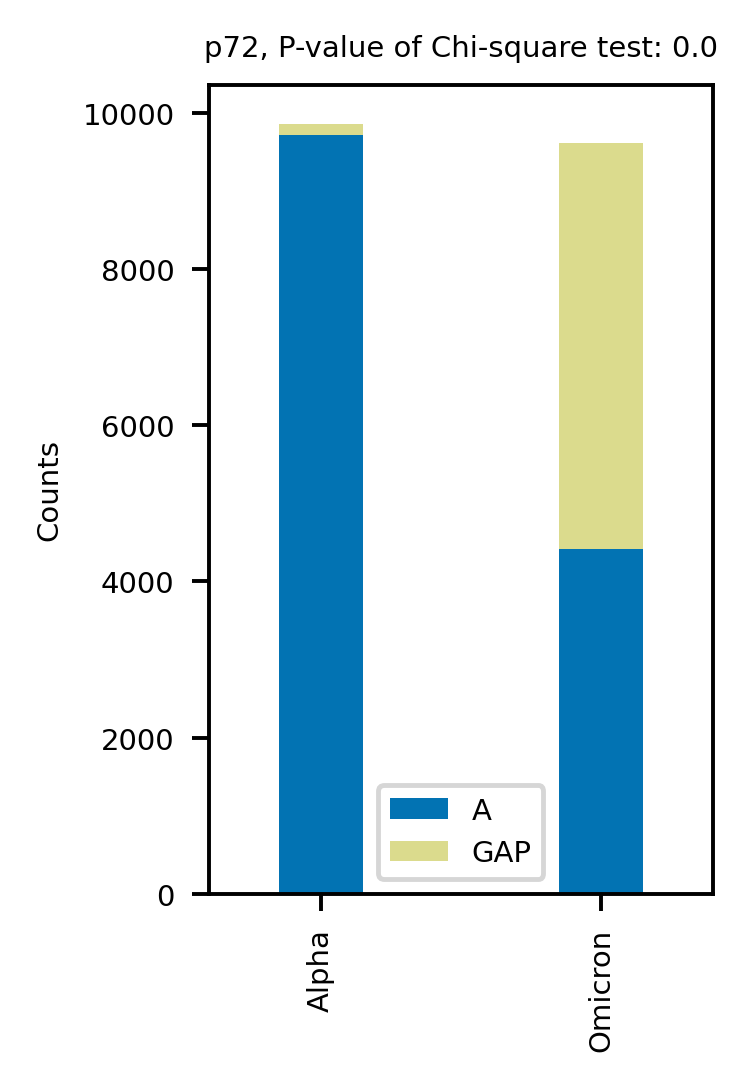

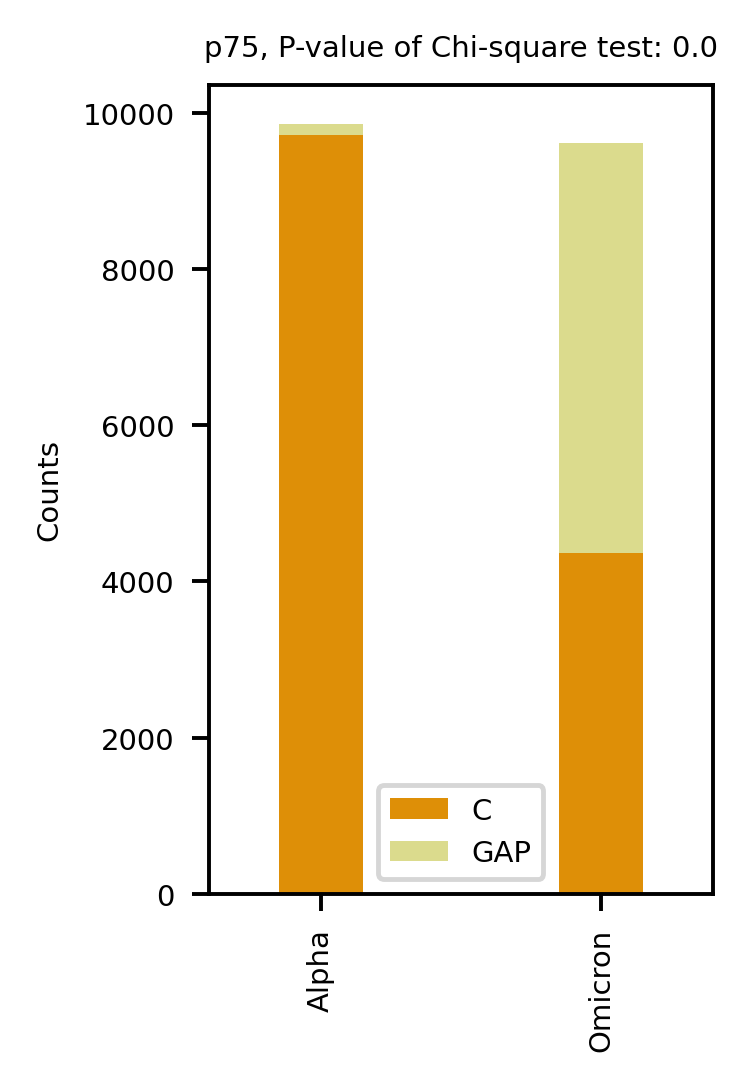

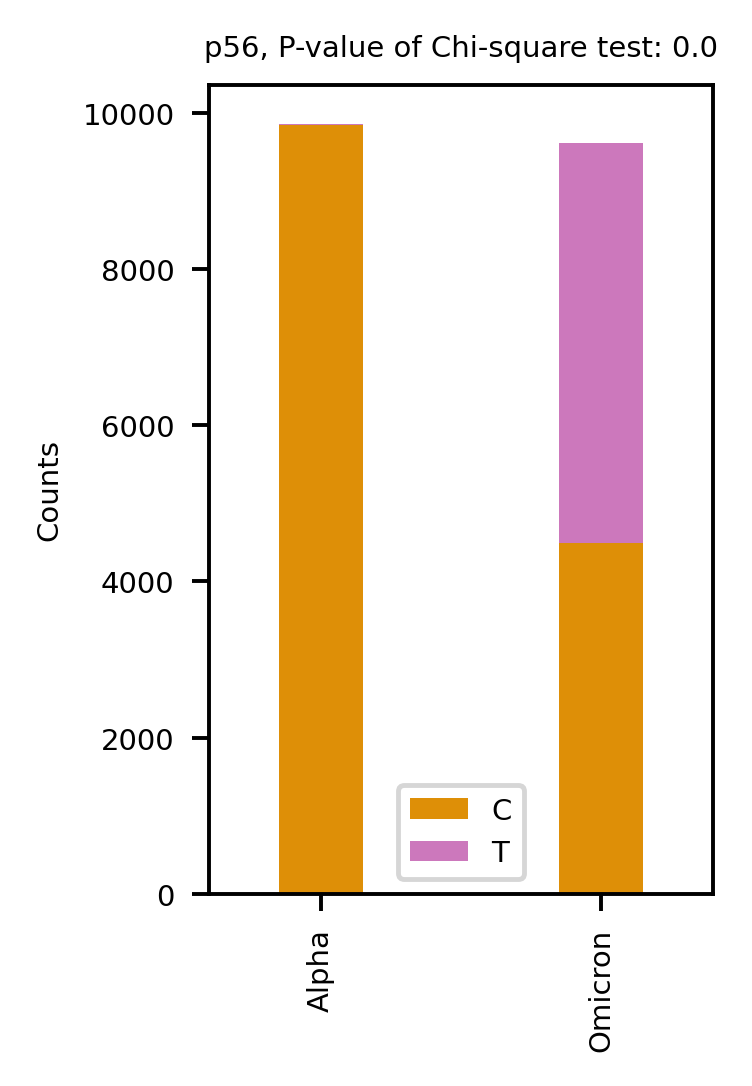

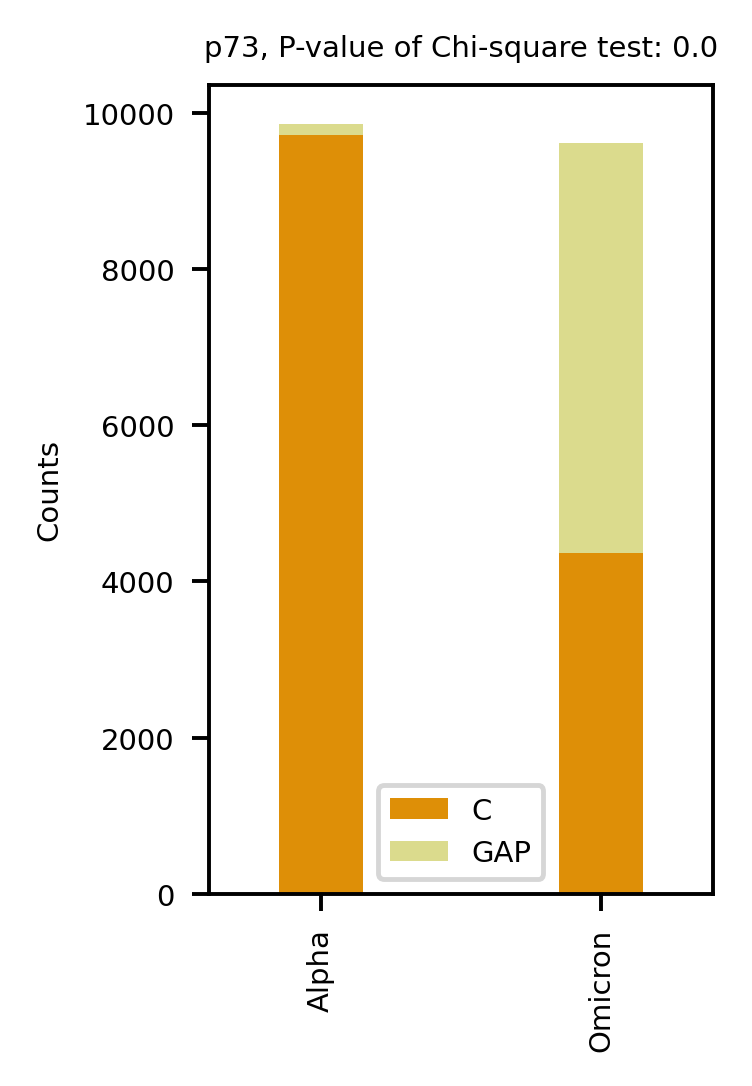

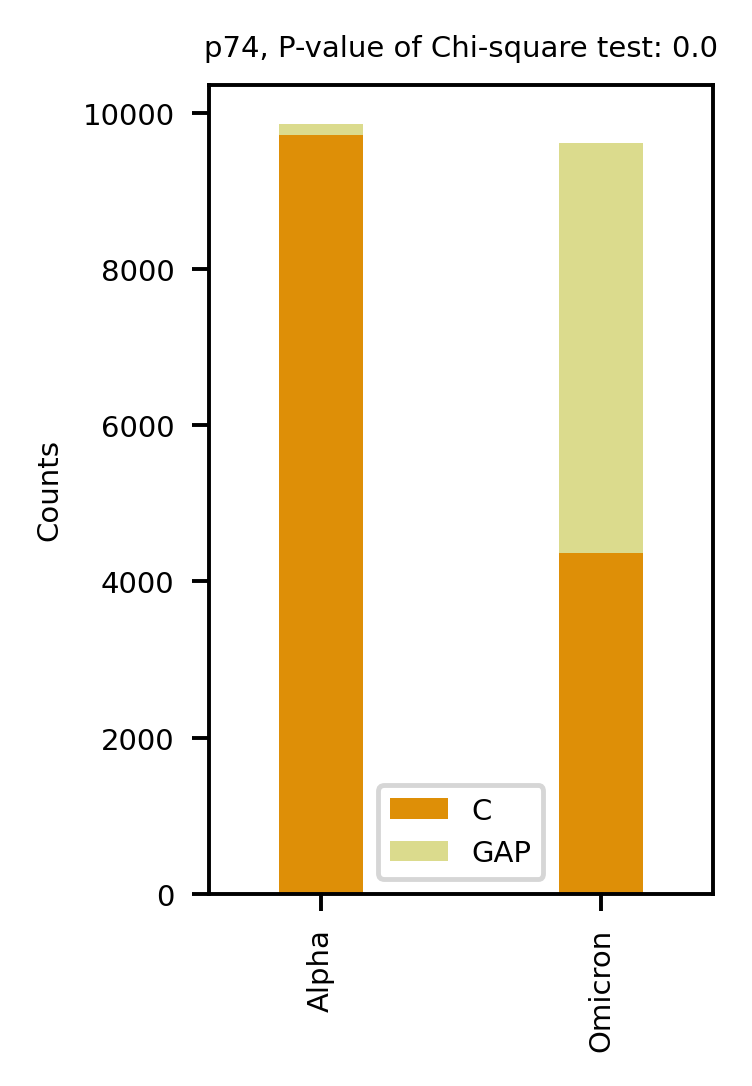

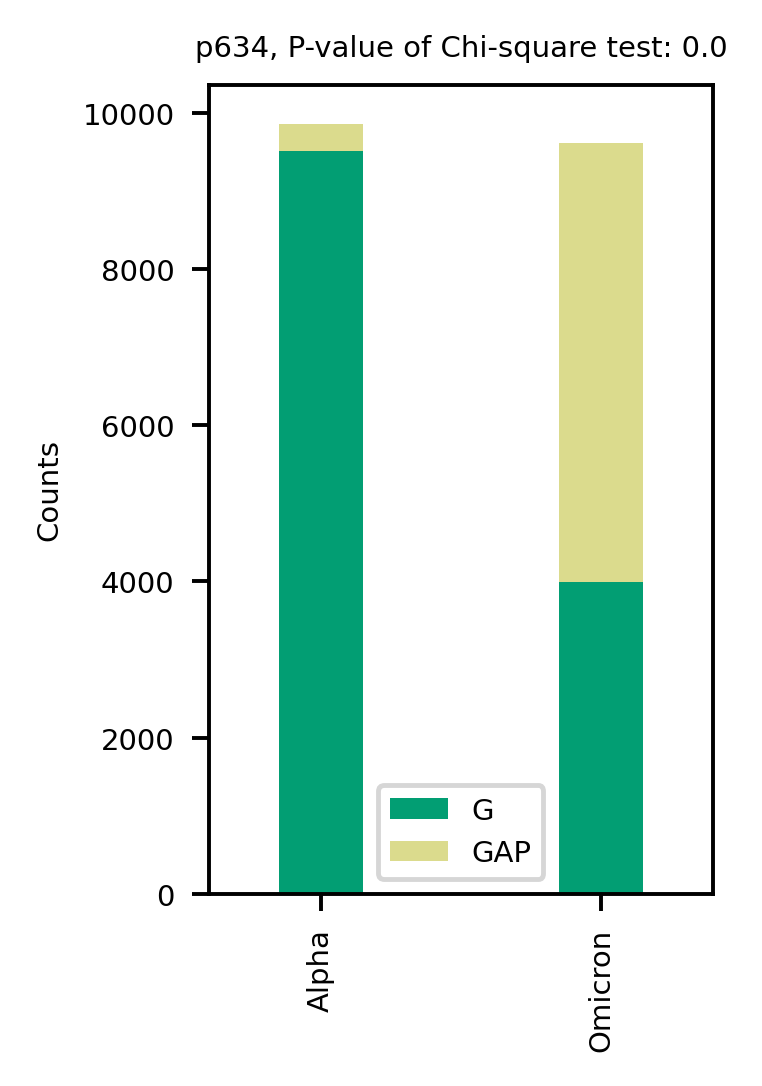

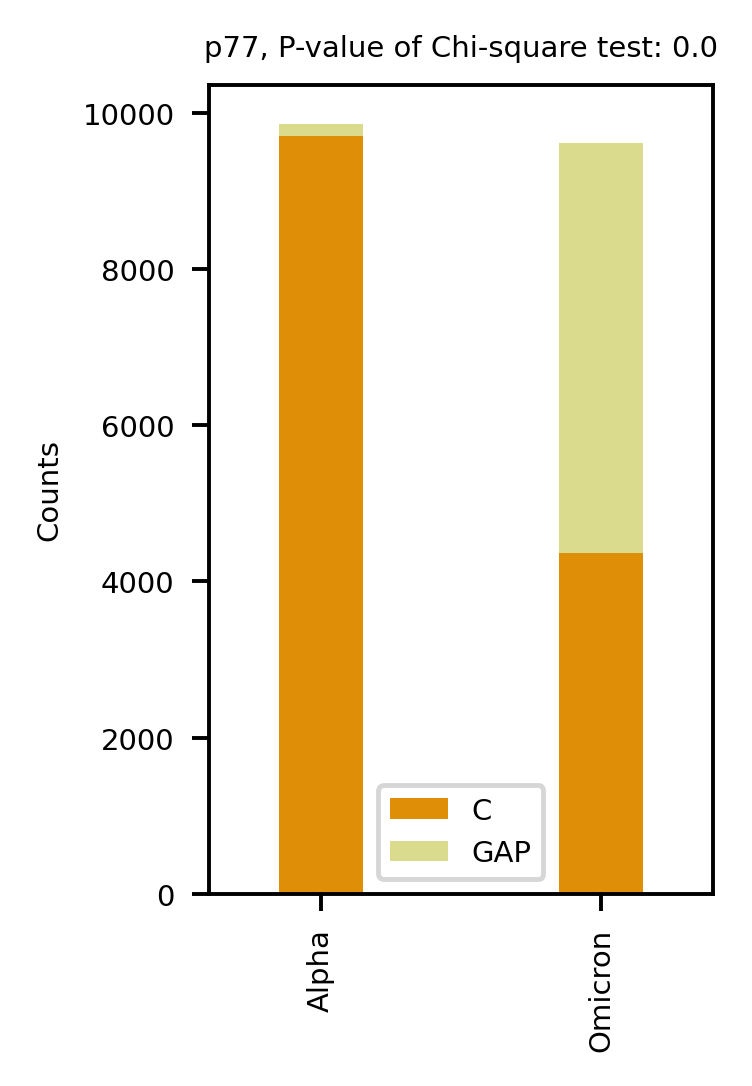

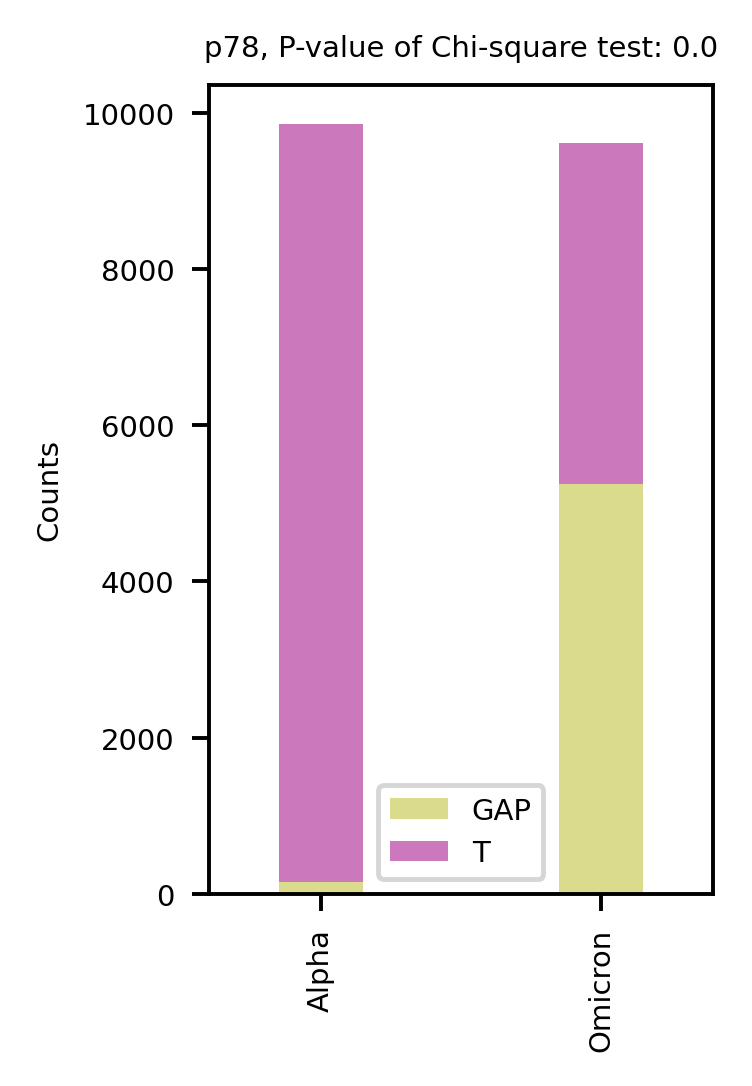

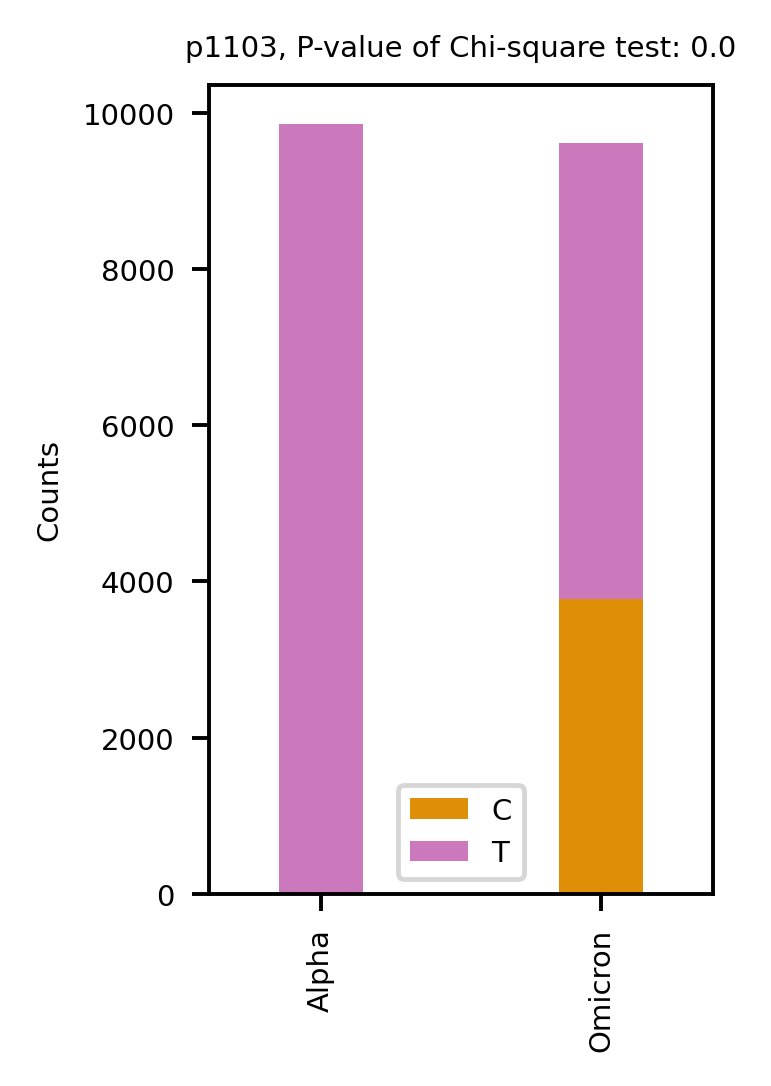

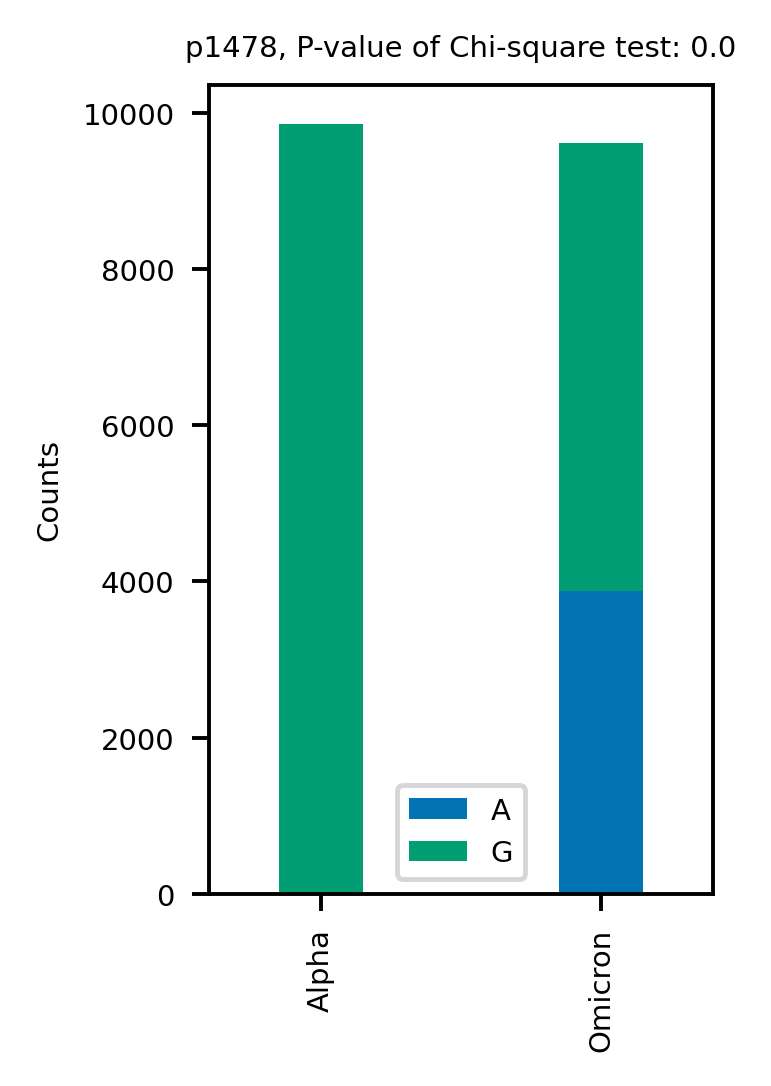

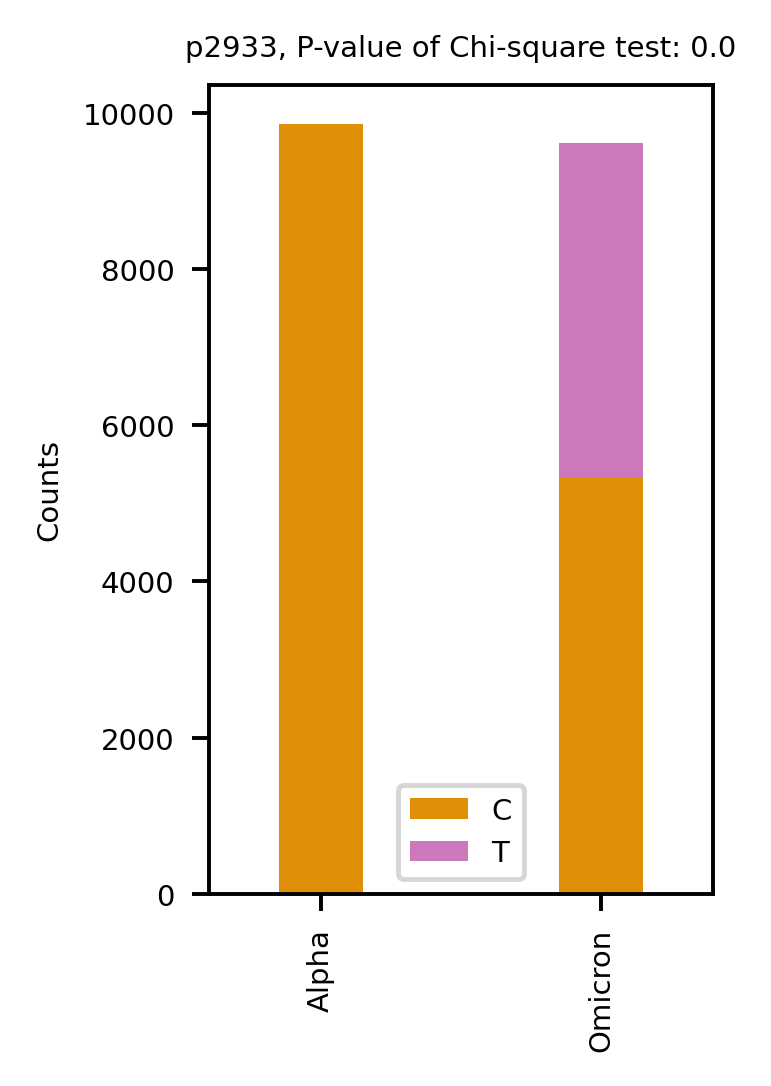

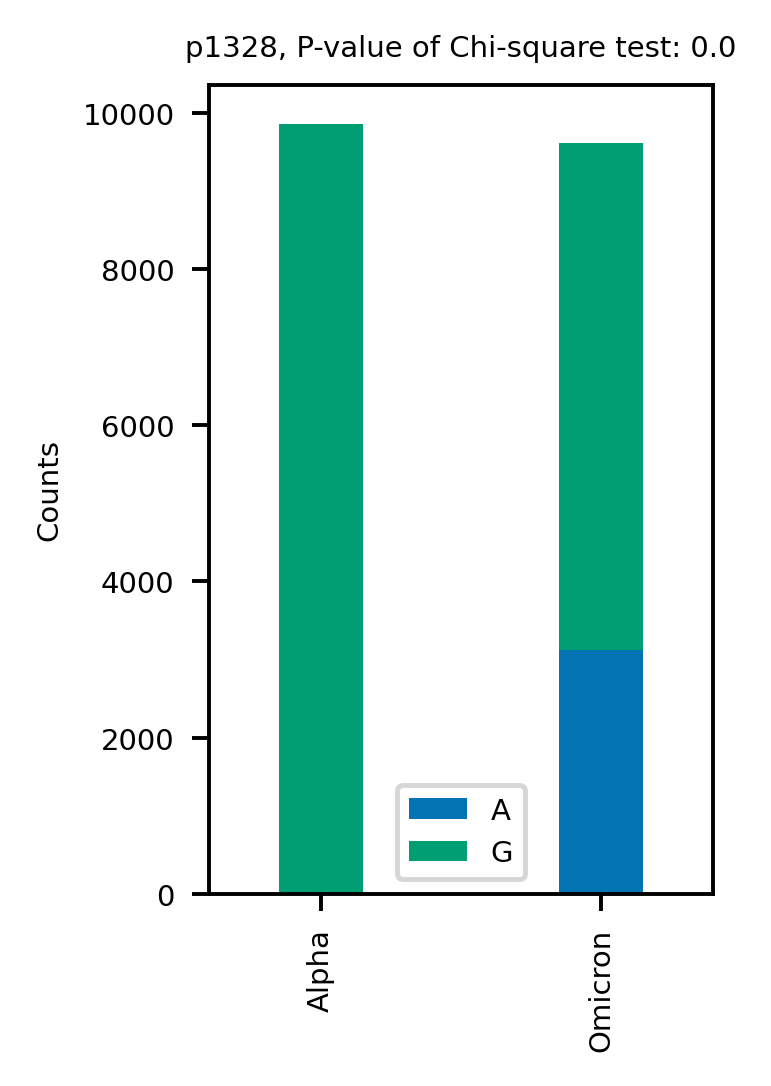

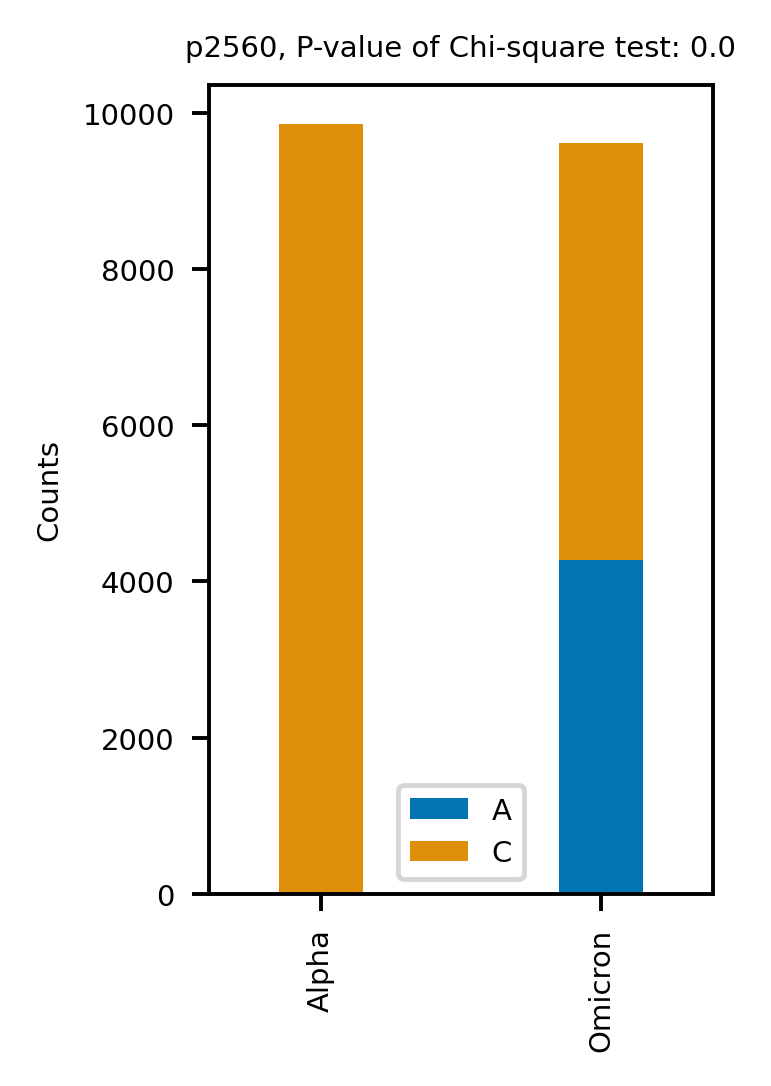

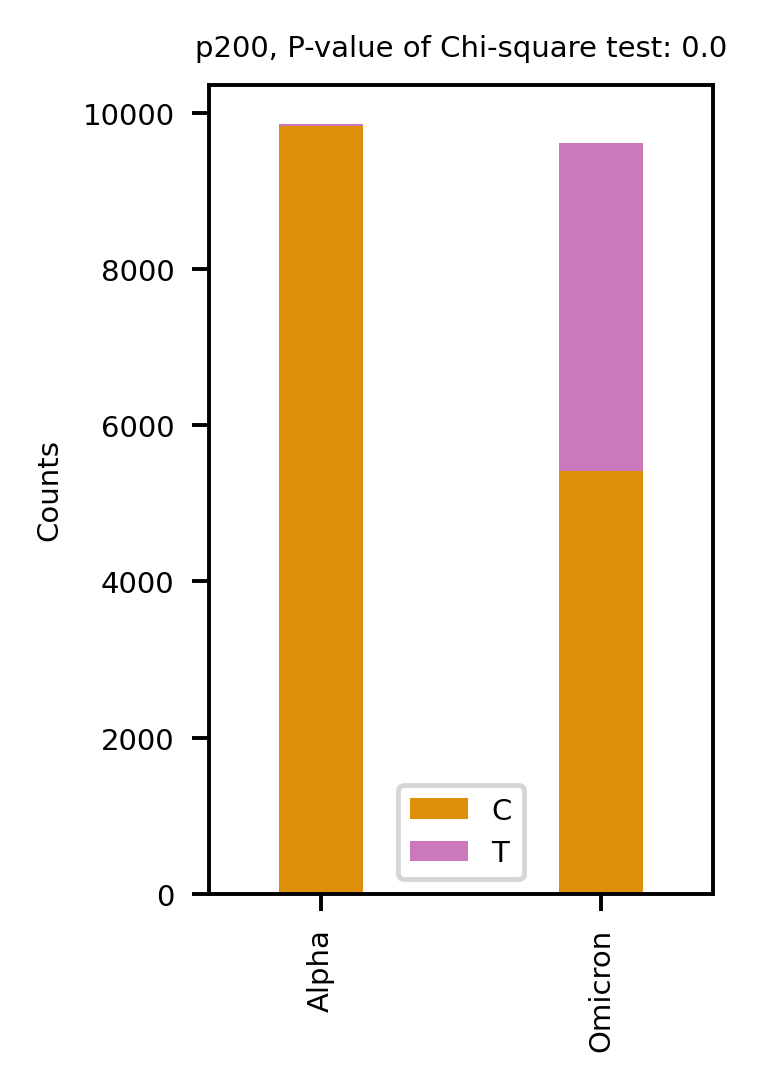

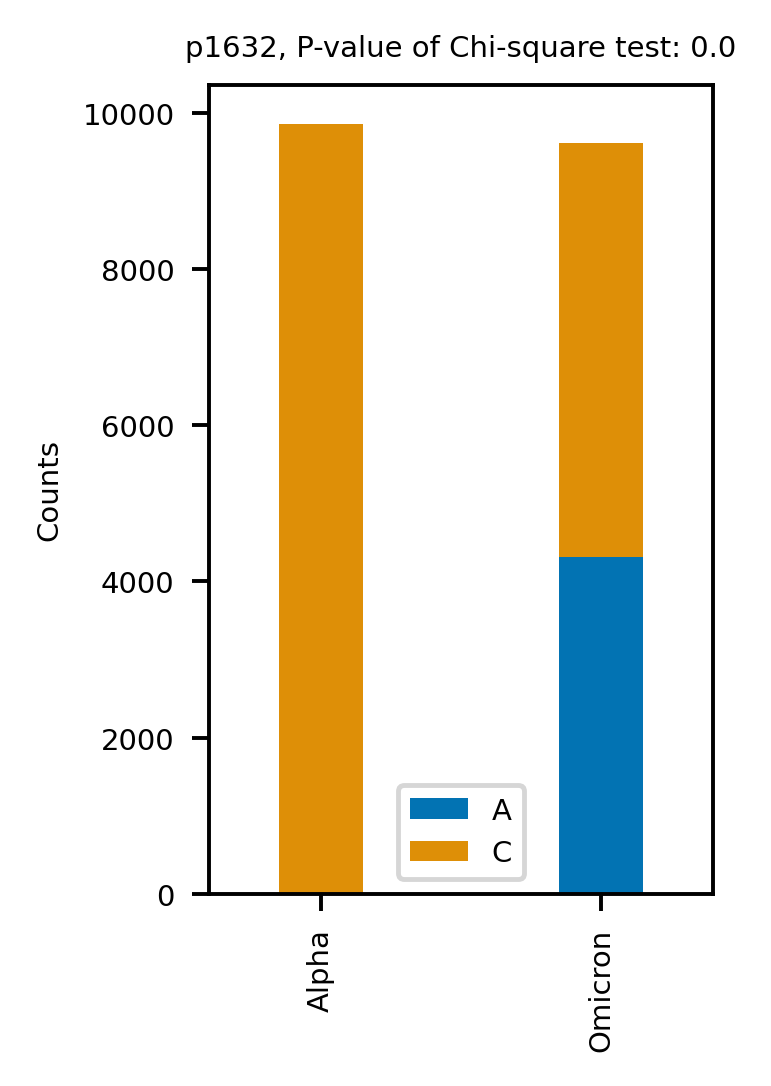

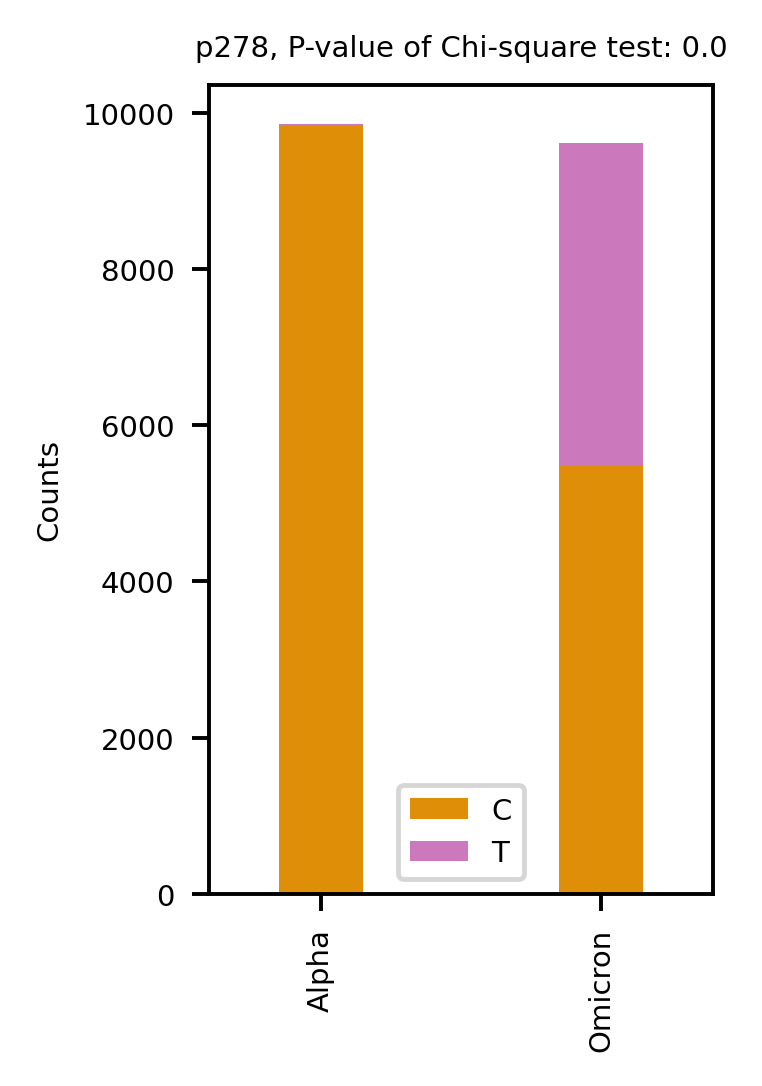

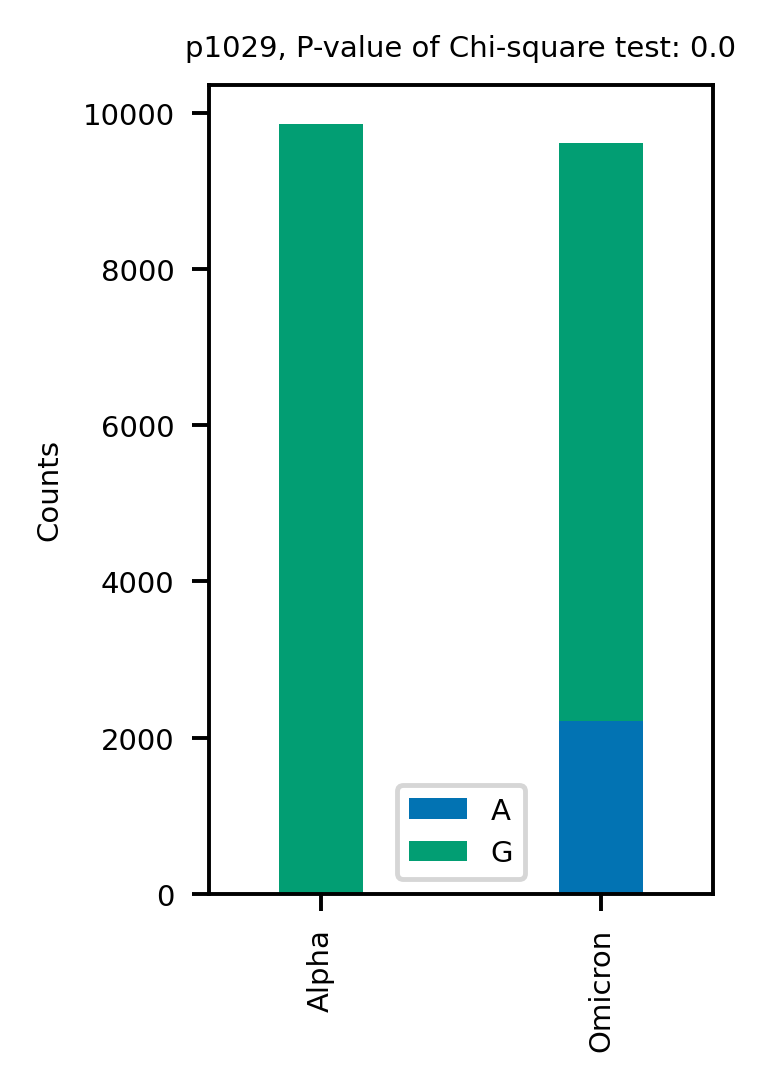

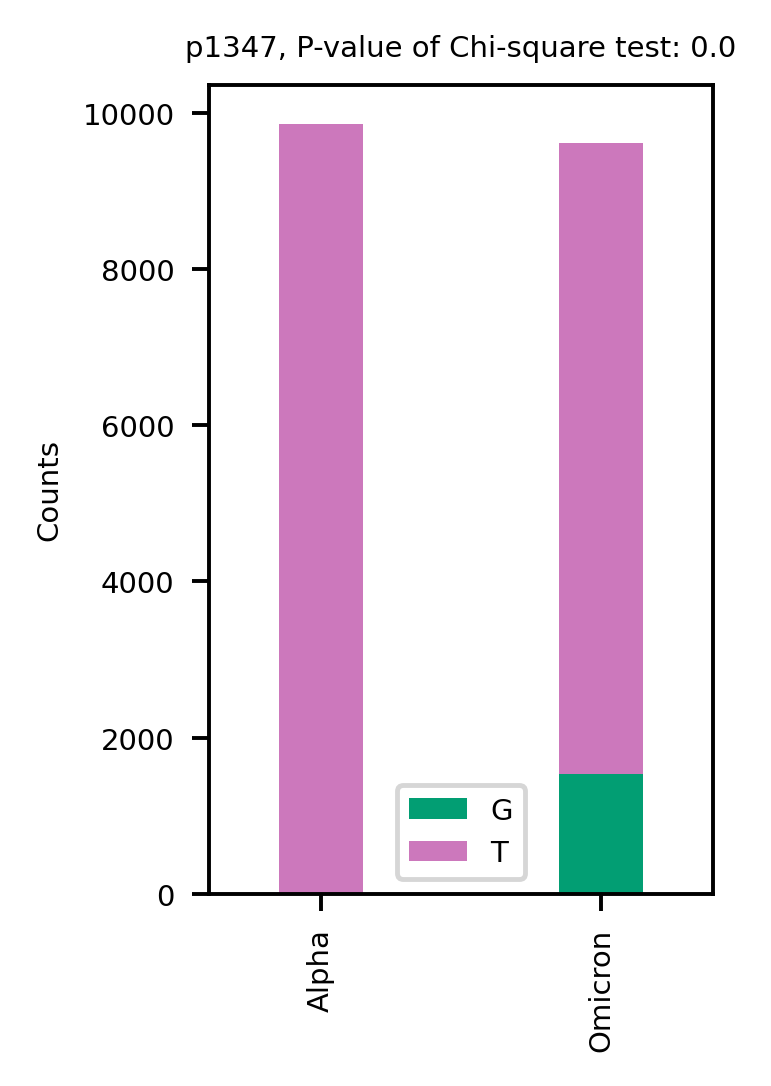

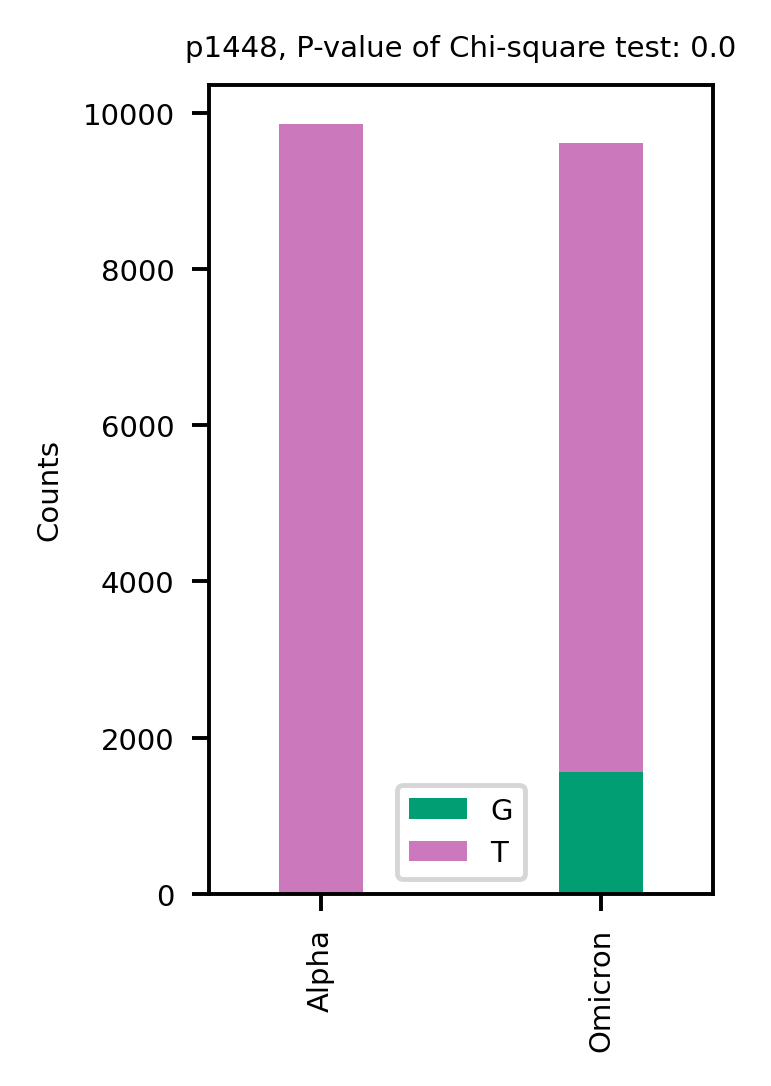

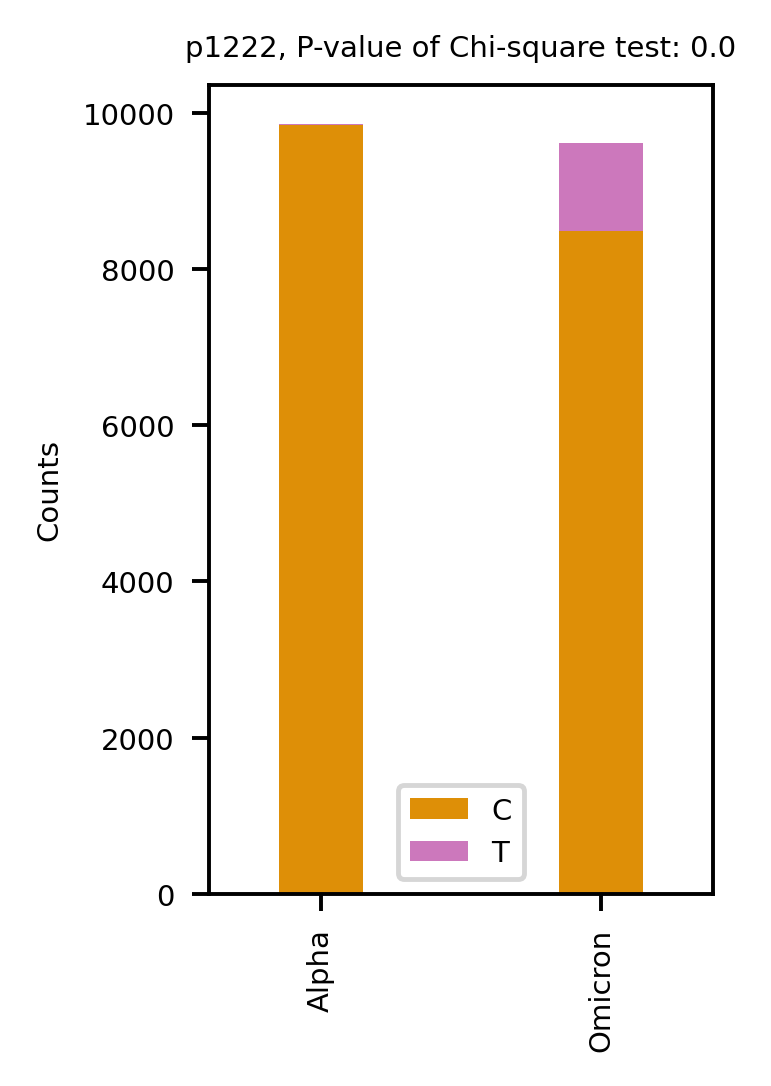

In [29]:
pl = plot_imp_all(final_models=top,
                  X_train=tr, y_train=y, 
                  aggregate_function='max',
                  model_type = ana_type,
                  report_dir=report_dir, max_plots=100,
                  figsize=(1.86, 3))

In [30]:
import joblib
load_rf = joblib.load(report_dir+'/rf.pkl')

In [31]:
load_rf

Pipeline(steps=[('prep',
                 Pipeline(steps=[('mc', MisCare(missing_threshold=0.25)),
                                 ('cc', ConstantCare()),
                                 ('ur', URareCare(threshold=0.05)),
                                 ('cc2', ConstantCare()),
                                 ('one_hot', CustomOneHotEncoder()),
                                 ('feature_selection',
                                  FeatureSelection(alpha=0.25, keep=True,
                                                   model_type='cl')),
                                 ('st_sc', CustomStandardScaler()),
                                 ('collinear_care',
                                  CollinearCare(dist_method='correlation',
                                                keep=True, threshold=0.25))])),
                ('rf', RandomForestClassifier(n_jobs=-1, random_state=123))])